In [24]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as lite
import sys
from pyne import nucname
from pyne.material import Material

In [25]:
# get sqlite cursor
filename = '../../db/1yr.sqlite'
con = lite.connect(filename)
# allows indexing with column name
con.row_factory = lite.Row
cur = con.cursor()

# Finding the Average Assembly and its Composition 

In [26]:
# first, find the average composition and recipe 
average_burnup = cur.execute('SELECT avg(discharge_burnup) FROM discharge').fetchone()[0]
average_enrichment = cur.execute('SELECT avg(initial_enrichment) FROM discharge').fetchone()[0]
print('AVG BURNUP: %f MWD/MTHM \nAVG ENRICHMENT: %f wt%% U235' %(average_burnup, average_enrichment))

AVG BURNUP: 36169.381303 MWD/MTHM 
AVG ENRICHMENT: 3.392045 wt% U235


In [27]:
# find assembly closest to this value:
min_diff_assem_id = cur.execute('SELECT assembly_id, min(abs(discharge_burnup - %f) + abs(initial_enrichment - %f)* 10000) '
                                'FROM discharge' %(average_burnup, average_enrichment)).fetchone()[0]
print(min_diff_assem_id)

324192


In [28]:
# how different is this assembly from the average?
chosen_assem = cur.execute('SELECT * FROM discharge WHERE assembly_id = %i' %min_diff_assem_id).fetchall()
burnup = chosen_assem[0]['discharge_burnup']
enrichment = chosen_assem[0]['initial_enrichment']

print(burnup)
print(enrichment)

# print error with the average value:
print('ERROR:')
enr_err = 100 * (average_enrichment - enrichment) / average_enrichment
bur_err = 100 * (average_burnup - burnup) / average_burnup
print('ENRICHMENT: %f %% \nBURNUP %f %%' %(enr_err, bur_err))

36172.0
3.394
ERROR:
ENRICHMENT: -0.057637 % 
BURNUP -0.007240 %


In [29]:
# save this assembly's composition to a dictionary
recipe = {}
total_mass = 0
for row in chosen_assem:
    isotope = nucname.name(row['isotope'])
    mass = float(row['total_mass_g'])
    total_mass += mass
    recipe[isotope] = mass

# normalize values:
for iso in recipe:
    print('%s : %f' %(iso, recipe[iso] / total_mass))
    recipe[iso] = recipe[iso] / total_mass

Th230 : 0.000000
Th229 : 0.000000
U238 : 0.965954
U236 : 0.004462
Zr93 : 0.000869
Y90 : 0.000000
Zr95 : 0.000001
U233 : 0.000000
U232 : 0.000000
Th232 : 0.000000
U235 : 0.010470
U234 : 0.000176
Pu239 : 0.007558
Pu240 : 0.002645
Pu241 : 0.001752
Pu242 : 0.000589
Ru106 : 0.000083
Sb124 : 0.000000
Se79 : 0.000005
Sb125 : 0.000010
Ru103 : 0.000000
Ra226 : 0.000000
Pu244 : 0.000000
Sn126 : 0.000024
Sm151 : 0.000016
Tc99 : 0.000870
Sr90 : 0.000552
Am241 : 0.000164
Am242M : 0.000001
C14 : 0.000000
Am243 : 0.000152
Cm242 : 0.000005
Cf251 : 0.000000
Cm244 : 0.000055
Cm243 : 0.000001
Cf249 : 0.000000
Ce144 : 0.000120
Cm245 : 0.000004
Cm246 : 0.000000
Cm247 : 0.000000
Cs134 : 0.000105
Cm248 : 0.000000
Cs137 : 0.001321
Cs135 : 0.000570
Eu154 : 0.000031
Eu152 : 0.000000
Kr85 : 0.000030
I129 : 0.000182
Nb94 : 0.000000
Np237 : 0.000559
Nb95 : 0.000001
Eu155 : 0.000008
H3 : 0.000000
Pa231 : 0.000000
Pd107 : 0.000269
Pm147 : 0.000142
Pu238 : 0.000241
Ag108M : 0.000000
Ag110M : 0.000000
Ac227 : 0.000000

# We store all the assemblies in a dictionary, one with the composition with UNF-ST&DARDS, and the other with recipe composition

In [30]:
### This can be done but takes way too long to actually get each assembly
def get_assembly_dict(cur):
    """ gets assembly evalution times, isotope, total_mass_g and total mass"""
    assem_dict = {}
    query = cur.execute('SELECT * FROM discharge').fetchall()
    count = 0
    percent_done = 0
    for row in query:
        iso = nucname.name(row['isotope'])
        mass = float(row['total_mass_g'])
        if row['assembly_id'] not in assem_dict.keys():
            # first of the assembly input data, initialize assem_dict[assembly_id] dict
            assem_dict[row['assembly_id']] = {'date': row['evaluation_date']}
            assem_dict[row['assembly_id']]['mass'] = 0
            assem_dict[row['assembly_id']]['comp'] = {iso: mass}
        else:
            assem_dict[row['assembly_id']]['comp'][iso] = mass
            assem_dict[row['assembly_id']]['mass'] += mass
        count += 1
        if len(query) // 50 == count:
            percent_done += 2
            print('%s %% DONE' %percent_done)
    return assem_dict

In [31]:
def get_lump_and_recipe_dict(cur):
    lump_dict = {}
    recipe_dict = {}
    query = cur.execute('SELECT evaluation_date, isotope, sum(total_mass_g) FROM discharge '
                        'GROUP BY evaluation_date, isotope').fetchall()
    for row in query:
        iso = nucname.name(row['isotope'])
        mass = float(row['sum(total_mass_g)'])
        if row['evaluation_date'] not in lump_dict.keys():
            lump_dict[row['evaluation_date']] = {}
            lump_dict[row['evaluation_date']]['mass'] = mass
            lump_dict[row['evaluation_date']]['comp'] = {iso: mass}
            
            recipe_dict[row['evaluation_date']] = {}
            recipe_dict[row['evaluation_date']]['mass'] = mass
            recipe_dict[row['evaluation_date']]['comp'] = recipe
        else:
            lump_dict[row['evaluation_date']]['comp'][iso] = mass
            lump_dict[row['evaluation_date']]['mass'] += mass
            
            recipe_dict[row['evaluation_date']]['mass'] += mass
    
    # normalize comp values:
    for key, value in lump_dict.items():
        for key2, value2 in lump_dict[key]['comp'].items():
            lump_dict[key]['comp'][key2] = lump_dict[key]['comp'][key2] / lump_dict[key]['mass']
    
    print('DONE')
    return lump_dict, recipe_dict


In [32]:
# this takes a while:
lump_dict, recipe_dict = get_lump_and_recipe_dict(cur)

DONE


# Then we convert the assembly to `pyne` material, for decay and analysis

In [33]:
def attach_pyne_material(assem_dict):
    for key, value in assem_dict.items():
        pyne_mat = Material(value['comp'], value['mass'])
        assem_dict[key]['mat'] = pyne_mat
    return assem_dict

In [34]:
lump_dict = attach_pyne_material(lump_dict)
recipe_dict = attach_pyne_material(recipe_dict)

# Then we decay the assemblies to 2020:

In [35]:
def find_diff_time_secs(year, month, day, evaluation_date):
    # the UNF-ST&DARDS data format is YYYY-MM-DD
    ev_year = int(evaluation_date[:4])
    ev_month = int(evaluation_date[5:7])
    ev_day = int(evaluation_date[8:])
    
    dyear = 0
    dmonth = 0
    dday = day - ev_day
    if dday < 0:
        dmonth -= 1
        dday += 30
    dmonth += month - ev_month
    if dmonth < 0:
        dyear -= 1
        dmonth += 12
    dyear += year - ev_year
    if dyear < 0:
        raise ValueError('Cannot go back in time man')
    
    time_in_sec = dyear * (365 * 24 * 3600) + dmonth * (30 * 24 * 3600) + dday * (24 * 3600)
    return time_in_sec

In [36]:
def decay_assemblies(assem_dict):
    # just put the pyne materials in there, other categories are unnecessary
    decayed_dict = {}
    for key, value in assem_dict.items():
        # to 2020-07-01
        decay_time = find_diff_time_secs(2020, 7, 1, key)
        decayed_dict[key] = {}
        decayed_dict[key]['mass'] = assem_dict[key]['mass']
        decayed_dict[key]['mat'] = assem_dict[key]['mat'].decay(decay_time)
    return decayed_dict

In [37]:
decayed_lump_dict = decay_assemblies(lump_dict)

decayed_recipe_dict = decay_assemblies(recipe_dict)

# We also import 2020-cooled data from UNF-ST&DARDS

In [38]:
data_2020 = np.genfromtxt('2020_comp.csv', delimiter=",", dtype=None)
data_dict = {}
data_dict['2020-07-01'] = {'mass': 0, 'comp': {}}
for data in data_2020:
    # in grams
    data_dict['2020-07-01']['comp'][data[0].decode('utf-8').replace('-', '')] = data[1] * 1e3
    
# normalize:
norm = sum(data_dict['2020-07-01']['comp'].values())
data_dict['2020-07-01']['mass'] = norm
for key, value in data_dict['2020-07-01']['comp'].items():
    data_dict['2020-07-01']['comp'][key] = value / norm

# add pyne material
data_dict['2020-07-01']['mat'] = Material(data_dict['2020-07-01']['comp'], data_dict['2020-07-01']['mass'])

/Users/13b/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


# We also import 1 year-cooled data from UNF-ST&DARDS

In [39]:
data_1yr = np.genfromtxt('1yr_comp.csv', delimiter=",", dtype=None)
data_dict2 = {}
data_dict2['1yr'] = {'mass': 0, 'comp': {}}
for data in data_1yr:
    # in grams
    data_dict2['1yr']['comp'][data[0].decode('utf-8').replace('-', '')] = data[1] * 1e3
    
# normalize:
norm = sum(data_dict2['1yr']['comp'].values())
data_dict2['1yr']['mass'] = norm
for key, value in data_dict2['1yr']['comp'].items():
    data_dict2['1yr']['comp'][key] = value / norm

# add pyne material
data_dict2['1yr']['mat'] = Material(data_dict2['1yr']['comp'], data_dict2['1yr']['mass'])

/Users/13b/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


# Then we compare the metrics:

In [40]:
import math

def nansum(dictionary):
    summ = 0 
    for key, value in dictionary.items():
        # skip metastable isotopes
        if str(key)[-1] == '1':
            continue
        if not math.isnan(value):
             summ += value
    return summ

def decay_heatz(assem_dict, time=0):
    total_heat = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        total_heat += nansum(after.decay_heat())
    return total_heat

def total_massz(assem_dict, time=0):
    total_mass = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        total_mass += value['mass']
    return total_mass

def activityz(assem_dict, time=0):
    activity = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        activity += nansum(after.activity())
    return activity

def isotopics(assem_dict, time=0):
    iso_dict = {}
    for key, value in assem_dict.items():
        for key2, value2 in value['mat'].mult_by_mass().items():
            if key2 not in iso_dict.keys():
                iso_dict[key2] = value2
            else:
                iso_dict[key2] += value2
    return iso_dict


In [41]:
post_lump = isotopics(decayed_lump_dict)
post_recipe = isotopics(decayed_recipe_dict)
pre_lump = isotopics(lump_dict)
pre_recipe = isotopics(recipe_dict)
post_data = isotopics(data_dict)
pre_data = isotopics(data_dict2)

In [42]:
# check pu-239 amount
# total mass -> should be the same
print('UNIT: T')

print('\nPost-decay')
print(post_lump[942390000] * 1e-6) 
print(post_recipe[942390000] * 1e-6)

print('\nPre-decay')
print(pre_lump[942390000] * 1e-6)
print(pre_recipe[942390000] * 1e-6)

print('\nData')
print(post_data[942390000] * 1e-6)
print(pre_data[942390000] * 1e-6)

UNIT: T

Post-decay
520.5243187492008
514.2153744519587

Pre-decay
520.8168827414128
514.5154422461604

Data
520.5033843020661
520.8168827414328


In [43]:
# check cs137 amount
print('CS 137')
print('UNIT: T')

print('\nPost-decay')
print(post_lump[551370000] * 1e-6) 
print(post_recipe[551370000] * 1e-6)

print('\nPre-decay')
print(pre_lump[551370000] * 1e-6)
print(pre_recipe[551370000] * 1e-6)

print('\nData')
print(post_data[551370000] * 1e-6)
print(pre_data[551370000] * 1e-6)

CS 137
UNIT: T

Post-decay
59.23121322194579
54.77074253847175

Pre-decay
92.67789281584608
89.93929878463527

Data
59.198813954451914
92.67789281584886


In [44]:
# check cs137 amount
print('U235')
print('UNIT: T')

print('\nPost-decay')
print(post_lump[922350000] * 1e-6) 
print(post_recipe[922350000] * 1e-6)

print('\nPre-decay')
print(pre_lump[922350000] * 1e-6)
print(pre_recipe[922350000] * 1e-6)

print('\nData')
print(post_data[922350000] * 1e-6)
print(pre_data[922350000] * 1e-6)

U235
UNIT: T

Post-decay
771.4277121073793
713.0780731879

Pre-decay
771.1020596111706
712.7471110021237

Data
771.3974311902376
771.1020596111667


In [45]:
# total mass -> should be the same
print('UNIT: T')

print('\nPost-decay')
print(total_massz(decayed_lump_dict) * 1e-6) 
print(total_massz(decayed_recipe_dict) * 1e-6)

print('\nPre-decay')
print(total_massz(lump_dict) * 1e-6)
print(total_massz(recipe_dict) * 1e-6)

print('\nData')
print(total_massz(data_dict) * 1e-6)
print(total_massz(data_dict2) * 1e-6)

UNIT: T

Post-decay
68072.03038959576
68072.03038959576

Pre-decay
68072.03038959576
68072.03038959576

Data
67984.97457236807
68072.03038959604


In [46]:
print('UNIT: MW')
print('\nPost-decay')
print(decay_heatz(decayed_lump_dict)) 
print(decay_heatz(decayed_recipe_dict))
print((decay_heatz(decayed_lump_dict) -decay_heatz(decayed_recipe_dict)) / decay_heatz(decayed_lump_dict))

print('\nPre-decay')
print(decay_heatz(lump_dict))
print(decay_heatz(recipe_dict))

print('\nData')
print(decay_heatz(data_dict))
print(decay_heatz(data_dict2))

UNIT: MW

Post-decay
61.314410524366686
53.90641038572524
0.12081988679802226

Pre-decay
279.53506225378135
255.23577956568477

Data
61.10359664916922
279.53506225378095


In [47]:
print('UNIT: Bq')
print('\nPost-decay')
print(activityz(decayed_lump_dict))
print(activityz(decayed_recipe_dict))
print( (activityz(decayed_lump_dict) - activityz(decayed_recipe_dict)) / activityz(decayed_lump_dict) )

print('\nPre-decay')
print(activityz(lump_dict))
print(activityz(recipe_dict))

print('\nData')
print(activityz(data_dict))
print(activityz(data_dict2))

UNIT: Bq

Post-decay
6.762448428754226e+20
6.337963861559325e+20
0.0627708398322084

Pre-decay
3.9134422027352555e+21
3.807563773396736e+21

Data
6.745408869011487e+20
3.913442202735231e+21


# Checking that our results match the data, we do a direct comparison between the decayed material using UNF-ST&DARDS and an Avg. Recipe

In [48]:
# lump the materials to one material to make this easier
def lump_dict_to_mat(assem_dict):
    out_mat = Material({'H1':1},1e-6)
    for key, val in assem_dict.items():
        out_mat = out_mat + assem_dict[key]['mat']
    return out_mat

In [49]:
decayed_lump_mat = lump_dict_to_mat(decayed_lump_dict)
decayed_recipe_mat = lump_dict_to_mat(decayed_recipe_dict)

In [50]:
z = decayed_lump_mat.decay_heat()
for key, val in z.items():
    print('%s: %f' %(key,val))

10010000: 0.000000
10030000: 0.000363
20030000: 0.000000
60140000: 0.000010
70140000: 0.000000
340790000: 0.000002
350790000: 0.000000
360830000: 0.000000
360850000: 0.369539
370850000: 0.000000
380900000: 3.860757
390900000: 18.402357
400900000: 0.000000
400930000: 0.000017
400950000: 0.000000
410930000: 0.000000
410940000: 0.000000
410950000: 0.000000
420940000: 0.000000
420950000: 0.000000
430990000: 0.000520
440990000: 0.000000
441010000: 0.000000
441030000: 0.000000
441060000: 0.001125
451030000: 0.000000
451050000: 0.000000
451060000: 0.181868
461050000: 0.000000
461060000: 0.000000
461070000: 0.000001
461080000: 0.000000
471070000: 0.000000
471080001: 15809720677157.234375
471090000: 0.000000
471100001: 6712512533.467713
481130000: 0.000000
491130000: 0.000000
491150000: 0.000000
501150000: 0.000000
501260000: 0.000033
511240000: 0.000000
511250000: 0.075505
511260000: 0.000396
521240000: 0.000000
521250000: 0.000000
521260000: 0.000000
521270000: 0.000000
531270000: 0.000000
53

In [51]:
def plot_decay_heat(mat, start_year, end_year, n_grid=100):
    heat_array = np.zeros(n_grid)
    time_array = np.linspace(0, ((end_year - start_year) * (3600 * 24 * 365)), n_grid)
    time_axis = np.linspace(start_year, end_year, n_grid)
    for index, time in enumerate(time_array):
        decayed = mat.decay(time)
        heat_array[index] = nansum(decayed.decay_heat())
    return time_axis, heat_array

def plot_activity(mat, start_year, end_year, n_grid=100):
    heat_array = np.zeros(n_grid)
    time_array = np.linspace(0, ((end_year - start_year) * (3600 * 24 * 365)), n_grid)
    time_axis = np.linspace(start_year, end_year, n_grid)
    for index, time in enumerate(time_array):
        decayed = mat.decay(time)
        heat_array[index] = nansum(decayed.activity())
    return time_axis, heat_array


In [52]:
# decay heat at discrete times

# to 2100
t_to_2100 = 80 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_2100).decay_heat())
rec = nansum(decayed_recipe_mat.decay(t_to_2100).decay_heat())
print(acc)
print(rec)
print((acc-rec)/acc)
print('\n')

t_to_3100 = 1080 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_3100).decay_heat())
rec = nansum(decayed_recipe_mat.decay(t_to_3100).decay_heat())
print(acc)
print(rec)
print((acc-rec)/acc)
print('\n')


24.278657937054568
23.63935117680674
0.026332046932137226


4.720085142701878
4.836015191702174
-0.024561008010532424




In [53]:
# activity at discrete times

# to 2100
t_to_2100 = 80 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_2100).activity())
rec = nansum(decayed_recipe_mat.decay(t_to_2100).activity())
print(acc)
print(rec)
print((acc-rec)/acc)
print('\n')


t_to_3100 = 1080 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_3100).activity())
rec = nansum(decayed_recipe_mat.decay(t_to_3100).activity())
print(acc)
print(rec)
print((acc-rec)/acc)
print('\n')


9.284691583522844e+19
8.76546183622094e+19
0.05592320893279417


5.541897853623782e+18
5.65404302387209e+18
-0.02023587825152304




In [54]:
time_acc, heat_acc = plot_decay_heat(decayed_lump_mat, 2020, 3100)
time_rec, heat_rec = plot_decay_heat(decayed_recipe_mat, 2020, 3100)

time_acc, act_acc = plot_activity(decayed_lump_mat, 2020, 3100)
time_rec, act_rec = plot_activity(decayed_recipe_mat, 2020, 3100)

In [55]:
err_heat = (heat_acc - heat_rec) / heat_acc * 100
err_act = (act_acc - act_rec) / act_acc * 100

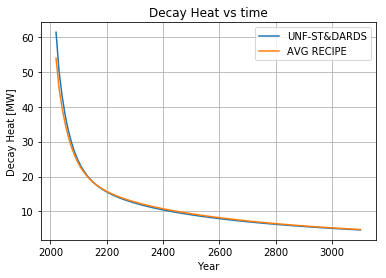

<function matplotlib.pyplot.close>

In [56]:
plt.plot(time_acc, heat_acc, label='UNF-ST&DARDS')
plt.plot(time_rec, heat_rec, label='AVG RECIPE')
plt.title('Decay Heat vs time')
plt.xlabel('Year')
plt.ylabel('Decay Heat [MW]')
plt.legend()
plt.grid()
plt.savefig('./images/heat.png', format='png')
plt.show()
plt.close

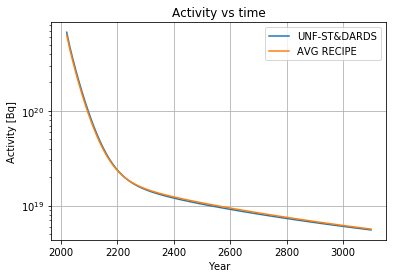

<function matplotlib.pyplot.close>

In [57]:
plt.semilogy(time_acc, act_acc, label='UNF-ST&DARDS')
plt.semilogy(time_rec, act_rec, label='AVG RECIPE')
plt.title('Activity vs time')
plt.xlabel('Year')
plt.ylabel('Activity [Bq]')
plt.legend()
plt.grid()
plt.savefig('./images/activity.png', format='png')
plt.show()
plt.close

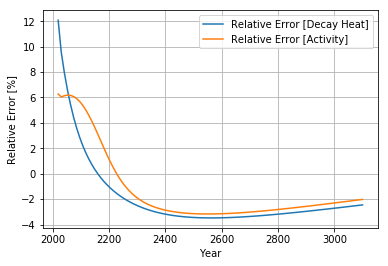

In [58]:
plt.plot(time_acc, err_heat, label='Relative Error [Decay Heat]')
plt.plot(time_acc, err_act, label='Relative Error [Activity]')
plt.xlabel('Year')
plt.ylabel('Relative Error [%]')
plt.legend()
plt.grid()
plt.savefig('./images/ha_err.png', format='png')
plt.show()
plt.close()

# Compare isotopic differences

In [59]:
def compare_isotope(acc_mat, rec_mat, isotope_list, rel_err=False):
    # convert to canonical / pyne-standard form
    isotope_list = [nucname.id(x) for x in isotope_list]
    iso_diff_dict = {}
    for iso in isotope_list:
        acc_qty = acc_mat.mult_by_mass()[iso]
        rec_qty = rec_mat.mult_by_mass()[iso]
        if rel_err:
            iso_diff_dict[nucname.name(iso)] = (acc_qty - rec_qty) / acc_qty * 100
        else:
            iso_diff_dict[nucname.name(iso)] = (acc_qty - rec_qty) * 1e-6
    return iso_diff_dict

def compare_element(acc_mat, rec_mat, zz_list, rel_err=False):
    el_diff_dict = {}
    for zz in zz_list:
        acc_qty = 0
        rec_qty = 0
        for key, val in acc_mat.mult_by_mass().items():
            if key // 10000000 == zz:
                acc_qty += acc_mat.mult_by_mass()[key]
                rec_qty += rec_mat.mult_by_mass()[key]
        if rel_err:
            el_diff_dict[zz] = (acc_qty - rec_qty) / acc_qty * 100
        else:
            el_diff_dict[zz] = acc_qty - rec_qty
    return el_diff_dict

def get_fissile_eq(mat, thermal=False):
    # from plutonium fuel - an assessment (NEA)
    eq = 0
    if thermal:
        eq += mat.mult_by_mass()[922350000] * 0.8
        eq += mat.mult_by_mass()[942380000] * (-1.0)
        eq += mat.mult_by_mass()[942390000] * (1.0)
        eq += mat.mult_by_mass()[942400000] * (-0.4)
        eq += mat.mult_by_mass()[942410000] * (1.3)
        eq += mat.mult_by_mass()[942420000] * (-1.4)
        eq += mat.mult_by_mass()[952410000] * (-2.2)
    else:
        # fast spectrum (super-phenix)
        eq += mat.mult_by_mass()[922350000] * 0.8
        eq += mat.mult_by_mass()[942380000] * (0.44)
        eq += mat.mult_by_mass()[942390000] * (1.0)
        eq += mat.mult_by_mass()[942400000] * (0.14)
        eq += mat.mult_by_mass()[942410000] * (1.5)
        eq += mat.mult_by_mass()[942420000] * (0.037)
        eq += mat.mult_by_mass()[952410000] * (-0.33)
    return eq

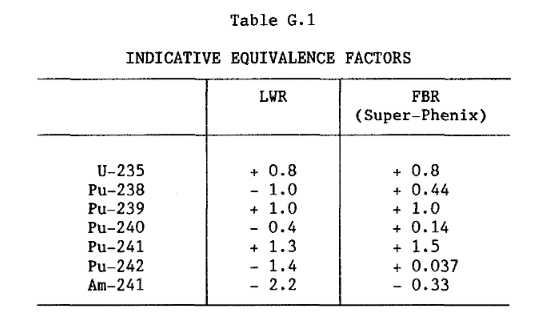

In [60]:
# Pu equiv factor from plutonium fuels (NEA)
from IPython.display import Image
Image('./images/pu_equiv.png')

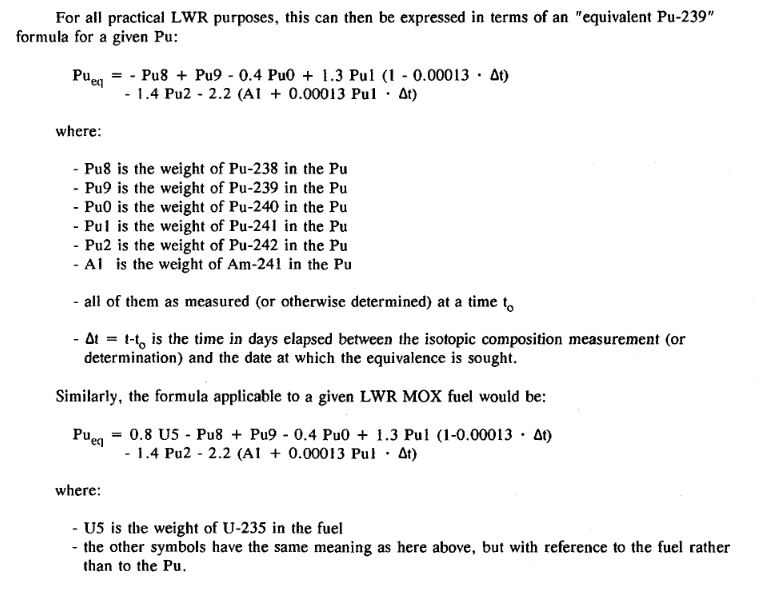

In [61]:
Image('./images/pu_equiv_eq.png')

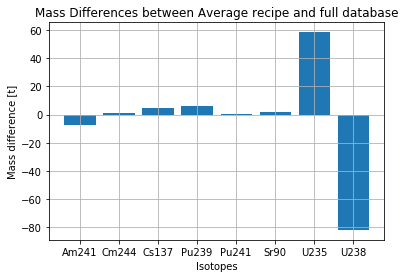

In [89]:
iso_list = ['Pu239', 'U238', 'U235', 'Am241', 'Cs137', 'Sr90', 'Pu241', 'Cm244']
iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_recipe_mat, iso_list)
plt.bar(iso_diff_dict.keys(), iso_diff_dict.values())
plt.grid()
plt.ylabel('Mass difference [t]')
plt.xlabel('Isotopes')
plt.title('Mass Differences between Average recipe and full database')
plt.savefig('./images/iso_mass.png', format='png')
plt.show()
plt.close()

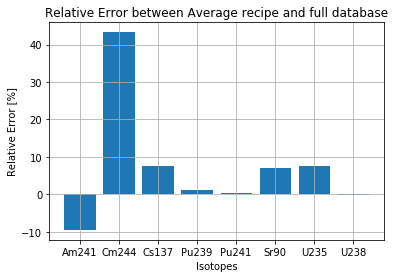

In [90]:
iso_list = ['Pu239', 'U238', 'U235', 'Am241', 'Cs137', 'Sr90', 'Pu241', 'Cm244']
iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_recipe_mat, iso_list, rel_err=True)
plt.bar(iso_diff_dict.keys(), iso_diff_dict.values())
plt.grid()
plt.ylabel('Relative Error [%]')
plt.xlabel('Isotopes')
plt.title('Relative Error between Average recipe and full database')
plt.savefig('./images/iso_rel.png', format='png')
plt.show()
plt.close()

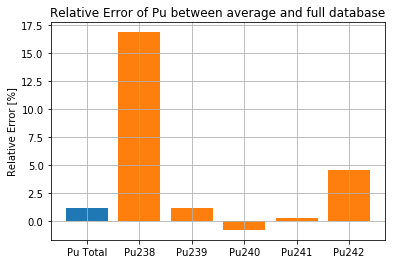

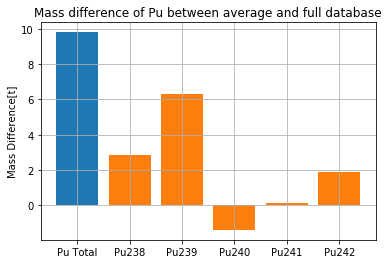

In [64]:
zz_list = [94]
el_diff_dict = compare_element(decayed_lump_mat, decayed_recipe_mat, zz_list, rel_err=True)
plt.bar(['Pu Total'], [el_diff_dict[94]])

iso_list = ['Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242']
iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_recipe_mat, iso_list, rel_err=True)

plt.bar(iso_diff_dict.keys(), iso_diff_dict.values())
plt.grid()
plt.ylabel('Relative Error [%]')
plt.title('Relative Error of Pu between average and full database')
plt.savefig('./images/pu_rel.png', format='png')
plt.show()
plt.close()

# actual mass difference
zz_list = [94]
el_diff_dict = compare_element(decayed_lump_mat, decayed_recipe_mat, zz_list, rel_err=False)
plt.bar(['Pu Total'], [el_diff_dict[94] * 1e-6])

iso_list = ['Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242']
iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_recipe_mat, iso_list, rel_err=False)

plt.bar(iso_diff_dict.keys(), np.array(list(iso_diff_dict.values())))
plt.grid()
plt.ylabel('Mass Difference[t]')
plt.title('Mass difference of Pu between average and full database')
plt.savefig('./images/pu_mass.png', format='png')
plt.show()
plt.close()

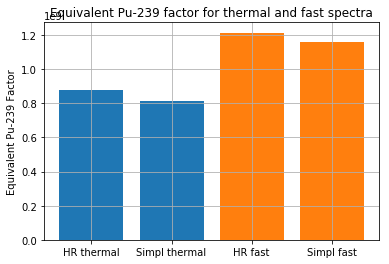

880.5953510527711
816.4789913324744
1214.0691471640257
1157.3605652658994


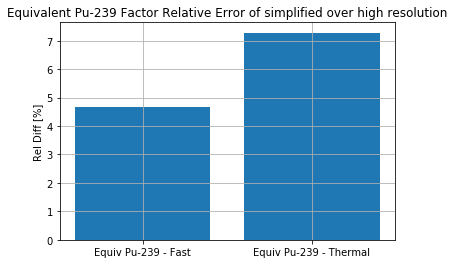

7.281024098485656
4.670951570641042


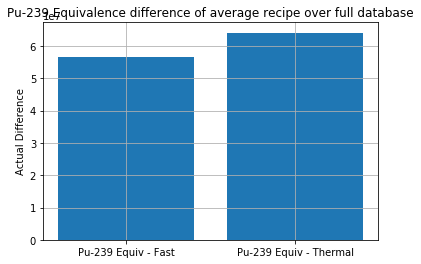

In [65]:
# eff pu241 for thermal and fast


acc_eq_thermal = get_fissile_eq(decayed_lump_mat, True)
acc_eq_fast = get_fissile_eq(decayed_lump_mat, False)
rec_eq_thermal = get_fissile_eq(decayed_recipe_mat, True)
rec_eq_fast = get_fissile_eq(decayed_recipe_mat, False)

rel_err_thermal = (acc_eq_thermal - rec_eq_thermal) / acc_eq_thermal * 100
rel_err_fast = (acc_eq_fast - rec_eq_fast) / acc_eq_fast * 100

plt.bar(['HR thermal', 'Simpl thermal'], [acc_eq_thermal, rec_eq_thermal])
plt.bar(['HR fast', 'Simpl fast'], [acc_eq_fast, rec_eq_fast])
plt.grid()
plt.ylabel('Equivalent Pu-239 Factor')
plt.title('Equivalent Pu-239 factor for thermal and fast spectra')
plt.savefig('./images/equiv_all.png', format='png')
plt.show()
plt.close()

print(acc_eq_thermal *1e-6)
print(rec_eq_thermal*1e-6)
print(acc_eq_fast*1e-6)
print(rec_eq_fast*1e-6)

plt.bar(['Equiv Pu-239 - Thermal', 'Equiv Pu-239 - Fast'], [rel_err_thermal, rel_err_fast])
plt.grid()
plt.ylabel('Rel Diff [%]')
plt.title('Equivalent Pu-239 Factor Relative Error of simplified over high resolution')
plt.savefig('./images/equiv_rel.png', format='png')
plt.show()
plt.close()

print(rel_err_thermal)
print(rel_err_fast)

plt.bar(['Pu-239 Equiv - Thermal', 'Pu-239 Equiv - Fast'], [acc_eq_thermal - rec_eq_thermal, acc_eq_fast - rec_eq_fast])
plt.grid()
plt.ylabel('Actual Difference')
plt.title('Pu-239 Equivalence difference of average recipe over full database')
plt.show()
plt.close()

In [66]:
# explain why there's not a difference in pu
# -> Pu 'saturates' after certain burnup and does not accumulate because it burns

# plot total pu diff
# plot pu quality diff

# fissile equivalenct (josh sent me a paper - pg120)
# find `Equivalent pu' (pg120)

# fuel that are older have more decay
# fuel that are younger have less time to decay

In [68]:
# get assembly_isotope_data
assem_dict = {}
total_mass = cur.execute('SELECT assembly_id, sum(total_mass_g), initial_enrichment, discharge_burnup '
                         'FROM discharge GROUP BY assembly_id').fetchall()
for row in total_mass:
    assem_dict[row['assembly_id']] = {'mass': row['sum(total_mass_g)'], 'comp': {}}
    assem_dict[row['assembly_id']]['burnup'] = float(row['discharge_burnup']) * 1e-3
    assem_dict[row['assembly_id']]['enrichment'] = float(row['initial_enrichment'])
    

In [69]:
isotopes = cur.execute('SELECT assembly_id, isotope, total_mass_g FROM discharge WHERE '
                        'isotope LIKE "pu%" OR isotope LIKE "u-235" OR isotope LIKE "am-241"').fetchall()
for row in isotopes:
    assem_dict[row['assembly_id']]['comp'][row['isotope']] = float(row['total_mass_g']) / float(assem_dict[row['assembly_id']]['mass'])

In [70]:
def attach_equiv(assem_dict):
    for key, value in assem_dict.items():
        ther_equiv = 0
        fast_equiv = 0
        for key2, value2 in value['comp'].items():
            if key2 == 'u-235':
                ther_equiv += value2 * 0.8
                fast_equiv += value2 * 0.8
            elif key2 == 'pu-238':
                ther_equiv -= value2 * 1.0
                fast_equiv += value2 * 0.44
            elif key2 == 'pu-239':
                ther_equiv += value2 * 1.0
                fast_equiv += value2 * 1.0
            elif key2 == 'pu-240':
                ther_equiv -= value2 * 0.4
                fast_equiv += value2 * 0.14
            elif key2 == 'pu-241':
                ther_equiv += value2 * 1.3
                fast_equiv += value2 * 1.5
            elif key2 == 'pu-242':
                ther_equiv -= value2 * 1.4
                fast_equiv += value2 * 0.037
            elif key2 == 'am-241':
                ther_equiv -= value2 * 2.2
                fast_equiv -= value2 * 0.33
            elif key2 == 'pu-244':
                # do nothing
                z=0
            else:
                print('THE UNCOUNTED ISOTOPE IS: %s' %key2)
        assem_dict[key]['fast_equiv'] = fast_equiv
        assem_dict[key]['thermal_equiv'] = ther_equiv
    return assem_dict

In [71]:
assem_dict = attach_equiv(assem_dict)

In [72]:
er = []
bu = []
fast_eq = []
thermal_eq = []
for key, val in assem_dict.items():
    er.append(val['enrichment'])
    bu.append(val['burnup'])
    fast_eq.append(val['fast_equiv'])
    thermal_eq.append(val['thermal_equiv'])

In [73]:
print('Pu239 Equivalance Factor for Average Comp\n')
print('Fast:')
print(assem_dict[324192]['fast_equiv'])
print('Thermal:')
print(assem_dict[324192]['thermal_equiv'])

Pu239 Equivalance Factor for Average Comp

Fast:
0.01900630500238818
Thermal:
0.015726138809854837


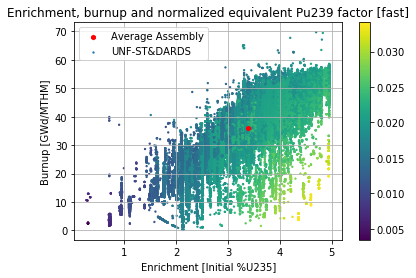

In [93]:
plt.scatter([3.39204], [36.16938], label='Average Assembly', color='red', marker='h', s = 20, zorder=1)
plt.scatter(er, bu, c=fast_eq, marker='.', zorder=-1, label='UNF-ST&DARDS', s=7)
plt.grid()
plt.xlabel('Enrichment [Initial %U235]')
plt.legend()
plt.ylabel('Burnup [GWd/MTHM]')
plt.title('Enrichment, burnup and normalized equivalent Pu239 factor [fast]')
plt.colorbar()
plt.savefig('./images/fast_all.png', format='png')
plt.show()
plt.close()

In [94]:
# find burnup and enrichment with max normalized equivalent pu239
indx = fast_eq.index(max(fast_eq))
max_er = er[indx]
max_bu = bu[indx]
print('Burnup for maximum pu239 equiv: %f' %max_bu)
print('Enrichment for maximum pu239 equiv: %f' %max_er)

Burnup for maximum pu239 equiv: 8.891000
Enrichment for maximum pu239 equiv: 4.602000


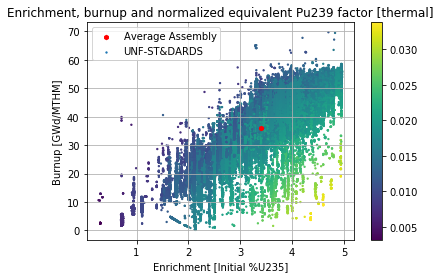

In [95]:
plt.scatter([3.39204], [36.16938], label='Average Assembly', color='red', marker='h', s = 20, zorder=1)
plt.scatter(er, bu, c=thermal_eq, marker='.', zorder=-1, label='UNF-ST&DARDS', s=7)
plt.grid()
plt.xlabel('Enrichment [Initial %U235]')
plt.legend()
plt.ylabel('Burnup [GWd/MTHM]')
plt.title('Enrichment, burnup and normalized equivalent Pu239 factor [thermal]')
plt.colorbar()
plt.savefig('./images/thermal_all.png', format='png')
plt.show()
plt.close()

In [96]:
# find burnup and enrichment with max normalized equivalent pu239
indx = thermal_eq.index(max(thermal_eq))
max_er = er[indx]
max_bu = bu[indx]
print('Burnup for maximum pu239 equiv: %f' %max_bu)
print('Enrichment for maximum pu239 equiv: %f' %max_er)

Burnup for maximum pu239 equiv: 8.891000
Enrichment for maximum pu239 equiv: 4.602000


In [97]:
# get assembly_isotope_data
assem_dict = {}
total_mass = cur.execute('SELECT assembly_id, sum(total_mass_g), evaluation_date, initial_enrichment, discharge_burnup '
                         'FROM discharge GROUP BY assembly_id').fetchall()
for row in total_mass:
    assem_dict[row['assembly_id']] = {'mass': row['sum(total_mass_g)'], 'comp': {}}
    assem_dict[row['assembly_id']]['burnup'] = float(row['discharge_burnup']) * 1e-3
    assem_dict[row['assembly_id']]['enrichment'] = float(row['initial_enrichment'])
    print(row['evaluation_date'][:4])
    assem_dict[row['assembly_id']]['year'] = int(row['evaluation_date'][:4])

1992
1992
1993
1992
1992
1993
1992
1992
1992
1993
1992
1993
1992
1995
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1993
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1993
1995
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1995
1993
1992
1995
1993
1993
1995
1995
1995
1993
1993
1993
1995
1995
1995
1993
1993
1995
1995
1993
1993
1993
1995
1993
1993
1993
1993
1993
1993
1993
1993
1995
1993
1995
1993
1995
1995
1993
1993
1993
1995
1993
1993
1993
1995
1995
1993
1993
1995
1993
1995
1995
1995
1993
1995
1993
1993
1993
1993
1995
1995
1993
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1996
1995
1995
1996
1995
1996
1996
1995
1995
1996
1996
1996
1995
1996
1995
1995
1995
1995
1995
1995
1995
1995
1996
1996
1996
1995
1995
1995
1996
1995
1996
1995
1996
1996
1996
1996
1996
1995
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1998
1998
1998
1998
1998
1998
1998


1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994


2002
2003
2003
2003
2002
2003
2002
2003
2002
2003
2002
2003
2003
2002
2002
2003
2003
2003
2002
2003
2002
2002
2002
2002
2003
2002
2002
2002
2002
2002
2002
2003
2003
2002
2002
2003
2002
2003
2002
2003
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2006
2011
2009
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2001
2001
2001
2001
2001
2001
2001
2001
2002
2001
2002
2001
2002
2001
2001
2002
2001
2002
2001
2002
2002
2001
2002
2002
2002
2001
2011
2002
2001
2001
2002
2002
2001
2001
2001
2002
2001
2002
2001
2001
2001
2002
2001


2001
2000
2000
2000
2000
2000
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2002
2002
2002
2002
2002
2002
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2001
2001
2000
2000
2001
2001
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2001
2000
2000
2000
2000
2000
2000
2000
2000
2001
2000
2000
2000
2000
2001
2001
2000
2000
2000
2001
2001
2000
2001
2001
2001
2001
2000
2001
2001
2000
2000
2000
2000
2001
2001
2000
2000
2000
2001
2000


1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990


1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1987
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992


1991
1991
1991
1991
1991
1991
1991
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1983
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985


1980
1980
1978
1981
1983
1980
1980
1978
1983
1983
1980
1980
1980
1980
1981
1978
1980
1981
1981
1980
1981
1980
1980
1983
1978
1980
1980
1980
1983
1983
1980
1981
1980
1978
1983
1983
1981
1978
1981
1978
1980
1983
1983
1980
1983
1983
1981
1980
1980
1980
1980
1980
1981
1980
1980
1983
1980
1980
1980
1980
1983
1980
1980
1978
1981
1980
1980
1981
1980
1980
1983
1980
1981
1981
1983
1983
1981
1983
1983
1980
1980
1981
1983
1981
1981
1980
1980
1981
1983
1980
1978
1981
1983
1980
1983
1981
1983
1980
1980
1981
1983
1983
1983
1983
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1995
1995
1995
1995
1995
1997
1997
1995
1995
1997
1997
1997
1997
1997
1997
1995
1995
1997
1997
1995
1997
1997
1997
1997
1997
1997
1997
1997
1997
1995
1995
1995
1995
1997
1995
1997
1997
1997
1997
1995
1997
1997
1995
1995
1995
1995
1997
1997
1997
1995
1995
1995
1995
1997
1997
1995
1995
1997
1997
1997
1997
1997
1997
1997


1990
1992
1990
1992
1990
1992
1992
1992
1990
1990
1990
1992
1990
1992
1992
1992
1990
1992
1992
1992
1990
1992
1992
1992
1992
1992
1990
1990
1992
1992
1992
1992
1990
1999
1990
1992
1992
1992
1992
1993
2001
1992
1990
1992
1990
1990
1992
1992
1990
1992
1992
1992
1990
1992
1992
1990
1990
1992
1990
1990
2001
1990
1990
1992
1992
1990
1990
1992
1992
1992
1990
1990
2001
2001
1990
1992
2001
1992
1990
1990
1990
1992
1992
1993
1993
1993
1993
1992
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1992
1992
1993
1993
1993
1993
1992
1992
1993
1993
1992
1993
1993
1992
1992
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1995
1995
1993
1995
1995
1993
1993
1995
1995
1993
1995
1993
1993
1993
1993
1993
1993
1993
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1993
1995
1995
1993
1995
1995
1995
1995
1993
1993
1993
1993
1995
1993
1995
1993
1995
1995
1996
1995
1995
1995
1996
1996
1996
1996
1996
1996
1995
1996
1995


1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1998
1998
1998
1998
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1998
1998
1998
1998
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1998
1997
1998
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1998
1997
1998
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1998
1998
1998
1998
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998


2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
1991
2003
1991
2003
1991
2003
1991
2003
1991
2003
1991
1991
1991
2003
1991
2003
1991
2003
1991
1991
2003
1991
2003
1991
2003
1991
2003
1991
2006
1991
2003
1991
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2006
2006
2003
2003
2003
2003
2003
2006
2003
2003
2003
2003
2003
2003
2003
2003
1991
1992
1992
1992
1992
1991
1991
1992
1991
1991
1991
1992
1991
1992
1991
1991
1991
1992
1992
1992
1992
1992
1992
1991
1992
1991
1992
1992
1992
1991
1992
1992
1991
1992
1992
1992
1992
1992
1992
1992
1992
1992
1991
1992
1992
1992
1991
1992
1991
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1991
1991
1992
1992
1994
1994
1994
1992
1992
1994
1992
1994
1992
1992
1994
1992
1994
1992
1992


1993
1993
1994
1993
1993
1993
1993
1991
1993
1993
1994
1996
1996
1996
1994
1996
1996
1996
1994
1994
1994
1996
1994
1996
1996
1996
1996
1994
1994
1996
1996
1994
1996
1994
1994
1994
1996
1994
1994
1996
1996
1994
1996
1994
1996
1996
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1996
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1996
1996
1996
1996
1997
1996
1996
1996
1996
1996
1997
1997
1997
1997
1997
1997
1996
1997
1997
1997
1997
1997
1997
1997
1997
1996
1996
1997
1996
1996
1996
1996
1996
1996
1996
1997
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1997
1997
1997
1997
2002
2002
1997
1997
2002
2002
1997
2002
2002
1997
1997
1997
1997
2002
2002
1997
2002
2002


2003
2003
2000
2003
2003
2003
2003
2003
2003
2003
2003
2003
2000
2000
2003
2003
2003
2003
2003
2000
2000
2000
2003
2003
2000
2000
2003
2003
2000
2003
2003
2000
2000
2000
2000
2000
2000
2003
2000
2003
2003
2000
2003
2003
2000
2000
2003
2000
2003
2000
2000
2000
2000
2000
2000
2003
2000
2000
2003
2003
2000
2000
2003
2003
2000
2000
2000
2003
2003
2000
2000
2003
2000
2000
2003
2003
2003
2003
2003
2003
2003
2003
2003
2000
2003
2003
2000
2003
2003
2000
2000
2003
2000
2000
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003


1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996


1997
1999
1999
1999
1997
1999
1999
1999
1997
1997
1999
1999
1999
1997
1999
1997
1999
1997
1997
1997
1999
1997
1997
1997
1999
1997
1999
1999
1999
1999
1999
1997
1999
1999
1999
1997
1999
1999
1999
1999
1997
1999
1999
1997
1999
1997
1999
1997
1997
1999
1997
1997
1999
1997
1999
1997
1999
1997
1997
1999
1999
1997
1999
1999
1999
1997
1999
1999
1999
1999
1997
1999
1999
1999
1997
1999
1997
1999
1999
1999
1999
1999
1997
1997
1999
1999
1999
1999
1999
1999
1999
1999
1997
1999
1999
1997
1997
1997
1997
1997
1999
1999
1997
1999
1999
1997
1997
1997
1999
1999
1999
1999
1999
1997
1999
1999
1997
1997
1997
1999
1997
1999
1997
1999
2003
2003
2003
2003
2003
2003
2003
2001
2001
2001
2001
2001
2001
2001
1999
2001
2001
2001
2001
2001
2001
2001
1999
2001
2001
2001
2001
1999
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001


1975
1976
1980
1976
1977
1977
1980
1975
1977
1976
1977
1977
1977
1980
1975
1977
1976
1977
1976
1976
1980
1976
1976
1975
1976
1975
1980
1976
1980
1980
1976
1980
1980
1977
1976
1977
1976
1976
1980
1980
1979
1980
1977
1980
1976
1980
1980
1980
1980
1977
1976
1976
1980
1976
1977
1980
1980
1980
1980
1980
1980
1980
1975
1980
1976
1980
1976
1977
1976
1976
1980
1979
1980
1980
1979
1975
1975
1976
1979
1977
1980
1975
1980
1975
1975
1977
1976
1977
1976
1979
1977
1976
1980
1980
1977
1980
1975
1977
1977
1977
1979
1977
1977
1977
1977
1975
1982
1976
1980
1977
1977
1977
1980
1976
1976
1975
1980
1977
1976
1976
1977
1977
1979
1977
1977
1980
1977
1980
1982
1979
1977
1977
1976
1980
1979
1979
1980
1975
1979
1977
1977
1979
1977
1980
1979
1979
1979
1979
1979
1977
1979
1980
1976
1980
1975
1980
1977
1980
1980
1980
1979
1979
1979
1977
1977
1977
1979
1976
1979
1977
1977
1980
1980
1976
1980
1977
1976
1975
1975
1975
1975
1979
1975
1980
1977
1977
1980
1975
1977
1977
1977
1980
1977
1979
1980
1979
1977
1980
1979
1977


2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
1996
1996
1996
1994
1996
1996
1996
1996
1994
1996
1996
1996
1996
1994
1996
1996
1996
1996
1996
1996
1996
1996
1996
1994
1996
1996
1996
1994
1996
1996
1994
1996
1996
1996
1996
1994
1996
1996
1996
1996
1996
1994
1996
1996
1996
1996
1994
1994
1996
1994
1994
1994
1994
1996
1996
1994
1996
1996
1994
1994
1994
1996
1994
1996
1996
1996
1996
1996
1996
1994
1996
1994
1996
1996
1996
1996
1994
1996
1996
1996
1996
1996
1996
1994
1996
1996
1996
1994
1996
1996
1996
1996
1996
1996
1996
1996
1998
1996
1996
1996
1996
1996
1996
1998
1998
1998
1996
1998
1998
1996
1996
1996
1998
1998
1998
1996
1998
1996
1998
1998
1998
1996
1998
1998
1998
1998
1998
1996
1996
1998
1998
1996
1996
1998
1998
1998
1996
1996
1998
1996
1996
1998
1996
1996
1996
1998
1996
1998
1996
1998
1998
1996
1998
1998
1996
1996
1998
1998
1998
1996
1996
1996
1998
1998
1996
1998
1998
1998
1998
1998
1998
1998
1998
1996


1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1981
1997
1981
1997
1981
1997
1981
1997
1984
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1984
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1984
1997
1984
1997
1981
1997
1984
1997
1981
1997
1984
1997
1981
1997
1981
1997
1984
1997
1984
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1981
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1985
1985
1986
1985
1985
1985
1985
1985
1985
1985
1985
1986
1985
1985
1985
1985
1985
1986
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1986
1985


2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2001
2003
2001
2001
2003
2001
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2007
2007
2007
2007
2003
2007
2007
2007
2007
2003
2003
2003
1998
1969
1969
1969
1969
1969
1970
1972
1972
1972
1972
1972
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973


1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1974
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1979
1979
1979
1979
1979


1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982


1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977


1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000


1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993


1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1998
1996
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
2006
1998
1998
2006
2006
1998
1998
1998
1998
1998
1998
1998
1998
1998
2006
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
2006
1998
1998
1998
2006
2006
2006
1998
1998
1998
1998
1998
1998
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990


1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995


1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994


2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2006
2000
2000
2006
2000
2006
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2003
2003
2003
2003
2003
2003
2003
2003
2008
2003
2003
2008
2003
2008
2003
2003
2003
2003
2008
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2001
2001


1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996


1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
2003
2003
2003
2003
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1997
1997
1997
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998


1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1999
1999
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987


1999
1999
1999
1999
2001
2001
2001
2001
1999
1999
1999
1999
2001
2001
2001
2001
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1991
1992
1994
1991
1994
1991
1994
1992
1992
1992
1992
1991
1991
1991
1992
1991
1991
1991
1991
1991
1992
1992
1991
1992
1991
1991
1992
1991
1991
1992
1991
1991
1992
1992
1991
1991
1991
1991
1992
1973
1973
1973
1973
1973
1973
1973
1973
1972
1972
1973
1973
1973
1972
1973
1972
1973
1973
1973
1973
1973
1973
1973
1973
1974
1973
1973
1974
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1978
1978
1978
1979
1978
1978
1978
1978
1978
1978
1978
1979
1978
1979
1978
1978
1979
1978
1978
1978
1978
1978
1978
1978
1979
1978
1978
1978
1978
1978
1978
1978
1978
1978
1979
1978
1978
1979
1978
1978
1979
1978
1978
1978
1978
1979
1978
1978
1978
1978
1979
1978
1979
1975
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1978
1979
1978


1996
1996
2002
1996
1996
1996
1996
2002
1996
1996
1996
2002
1996
1996
2002
2002
2002
2002
2002
2000
2000
2000
2000
1998
1998
2000
2000
2000
1998
1998
2000
2000
2000
1998
1998
1998
1998
1998
1998
1998
2000
1998
2000
1998
2000
2000
1998
1998
2000
1998
2000
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
2000
1998
2000
2000
2000
1998
2000
1998
2000
2000
2000
1998
1998
1998
1998
1998
1998
1998
1998
1998
2010
2002
2006
2008
2002
2002
2002
2000
2000
2000
2000
2000
2000
2002
2002
2000
2002
2000
2000
2000
2000
2000
2000
2002
2000
2000
2000
2000
2000
2000
2000
2002
2002
2002
2002
2000
2000
2000
2000
2002
2002
2002
2002
2000
2000
2000
2000
2000
2000
2000
2000
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002


1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992


1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993


1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994


1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991


1991
1991
1991
1991
1991
1991
1991
1991
1991
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997


2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
1994
1996
1994
1994
1996
1994
1996
1996
1994
1994
1994
1996
1996
1997
1997
1997
1996
1996
1997
1996
1996
1996
1997
1996
1997
1996
1997
1997
1997
1996
1996
1997
1996
1996
1997
1996
1996
1996
1996
1997
1997
1996
1996
1997
1996
1997
1996
1996
1996
1997
1996
1997
1996
1996
1996
1996
1997
1996
1996
1996
1997
1996
1996
1996
1997
1996
1997
1996
1996
1996
1997
1997
1996
1996
1996
1997
1996
1996
1996
1996
1996
1996
1996
1997
1996
1997
1996
1997
1996
1996
1997
1996
1997
1996
1996
1997
1997
1996
1996
1996
1996
1996
1996
1997
1996
1997
1996
1996
1996
1996
1996
1996
1996
1996
1997
1996
1996
1996
1997
1996
1996
1996
1996
1996
1996
1996
1996
1997
1996
1996
1996
1996
1997
1996
1997
1996
1996
1997
1997
1996
1996
1996
1997
1996
1996
1996
1996
1996
1996
1997
1997


1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997


1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996


1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987


1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
1997
1997
2006
2006
2006
2006
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999


1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987


1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1975
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976
1976


1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993


2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973


1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992


1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
2001
2001
2001
2001
2001
2001
2001


1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992


1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1989
1989
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990


1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1987
1987
1987
1987
1993
1992
1993
1992
1992
1992
1993
1992
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1992
1993
1993
1993
1993


1997
1996
1996
1996
1996
2001
2001
2001
2001
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
2001
2001
2001
2001
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
2001
2001
2001
2001
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
2001
2001
2001
2001
1996
1996
1996
1996
1996
1996
1996
1996
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1996
1996
1996
1996
1997
1997
1997
1997
1996
1996
1996
1996
1996
1996
1996
1996
1997
1997
1997
1999
1999
1999
1999
1997
1997
1997
1997
1999
1999
1999
1999
1999
1999
1999
1999
1997
1997
1997
1997
1999
1999
1999
1999
1997
1997
1997
1997
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999


2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2001
2001
2001
2001
2001
2001
2001
2001
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2001
2001
2001
2001
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998


1993
1993
1995
1995
1995
1995
1995
1993
1993
1993
1993
1993
1993
1995
1993
1995
1993
1993
1995
1993
1995
1995
1995
1995
1995
1996
1996
1996
1996
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1996
1996
1996
1996
1995
1995
1995
1995
1996
1996
1996
1996
1995
1995
1995
1995
1995
1995
1995
1995
1996
1996
1996
1996
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1995
1995
1995
1995
1996
1996
1996
1996
1995
1995
1995
1995
1995
1995
1995
1995
1996
1996
1996
1996
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1996
1996
1996
1996
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1996
1996
1996
1996
1995
1995
1995
1995
1995
1995
1995


1994
1996
1994
1994
1994
1994
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
2003
2003
2003
2003
1999
1999
1999
1990
1990
1990
1990
1990
1991
1990
1990
1991
1990
1990
1990
1990
1991
1990
1990
1990
1990
1991
1990
1990
1990
1990
1990
1990
1990
1990
1991
1990
1990
1990
1991
1990
1990
1990
1991
1991
1991
1990
1991


1994
1994
1994
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1998
1998
1998
1998
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1998
1998
1998
1998
1996
1996
1996
1996
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1996
1996
1996
1996
1996
1996
1996
1996
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1996
1996
1996
1996
1998
1998
1998
1996
1996
1996
1996
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1996
1996
1996
1996
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998


1988
1988
1988
1992
1992
1988
1988
1988
1988
1992
1992
1988
1988
1988
1988
1988
1988
1992
1992
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1992
1992
1988
1988
1988
1992
1992
1988
1988
1988
1993
1993
1993
1993
1993
1993
1993
1995
1993
1995
1995
1993
1995
1993
1993
1993
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1993
1993
1993
1995
1993
1995
1995
1993
1995
1995
1993
1993
1993
1993
1993
1993
1995
1993
1993
1995
1993
1995
1995
1993
1995
1995
1995
1993
1993
1995
1995
1993
1993
1995
1993
1995
1995
1993
1995
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1988
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1995
1995
1995
1997
1997
1995
1995
1995
1995
1995
1997
1995
1997
1995
1995
1995
1995
1995
1997
1995
1995
1995
1997
1995
1995
1995
1995
1995
1995
1995
1995
1997
1995
1995
1997
1997
1995
1995
1997
1995
1995
1995
1995
1995
1995
1995
1997
1997
1997
1995
1995
1997
1995
1995
1995
1995
1995
1995
1995
1995


2001
2001
2001
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
1999
1999
1999
1999
1999
1999
1999
1999
2001
2001
2001
2001
2001
2001
2001
2001
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
1999
1999
1999
1999
1999
1999
1999
1999
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
1999
1999
1999
1999
2001
2001
2001
2001
1999
1999
1999
1999
1999
1999
1999
1999
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
1999
1999
1999
1999
1999
1999
1999
1999
2001
2001
2001
2001
2001
2001
2001
2001
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
1999
2001
2001
2001
2001
2001
2001
2001
2001
1999
1999
1999
1999
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003


1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1996
1994
1994
1996
1996
1994
1994
1996
1994
1994
1996
1994
1994
1996
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1996
1996
1994
1994
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1992
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1992
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1994
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996


1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987


1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991


2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2004
2002
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989


1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
1984
1984
1984
1984
1984
1984
1984
1984


1993
1993
1993
1993
1993
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
2006
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2002
2002
2002
2002
2002
2002
2002
2002


1988
1988
1988
1986
1988
1986
1991
1988
1988
1988
1989
1989
1988
1988
1989
1988
1988
1989
1988
1989
1989
1988
1989
1988
1989
1989
1989
1988
1989
1989
1988
1989
1989
1988
1988
1989
1989
1989
1988
1991
1989
1989
1989
1989
1991
1989
1989
1991
1989
1991
1989
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1989
1989
1991
1989
1991
1991
1991
1989
1989
1991
1989
1989
1989
1989
1991
1991
1991
1991
1989
1991
1991
1989
1991
1991
1991
1989
1991
1991
1989
1989
1989
1989
1989
1991
1989
1991
1989
1989
1989
1989
1989
1989
1991
1989
1989
1989
1989
1989
1989
1989
1989
1992
1992
1992
1991
1992
1991
1991
1991
1991
1992
1991
1991
1992
1992
1992
1991
1991
1991
1991
1992
1991
1991
1992
1992
1991
1992
1992
1992
1991
1991
1991
1991
1991
1992
1991
1992
1992
1991
1992
1991
1991
1992
1992
1991
1991
1991
1992
1992
1992
1991
1992
1991
1992
1992
1992
1992
1992
1991
1992
1992
1991
1991
1991
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1995
1995
1995
1995
1992
1992
1992
1992
1992
1992
1992
1992
1992


1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996


1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981


1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1979
1979
1979
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980


2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2002
2000
2000
2000
2000
2000
2000
2000
2000
2002
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2002
2000
2000
2000
2000
2000
2000
2000
2000
2002
2000
2000
2000
2000
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2006
2001
2002
2002
2001
2002
2001
2001
2001
2001
2002
2001
2001
2001
2001
2001
2001
2001
2001
2002
2002
2002
2002
2002
2002
2002
2002
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2002
2001
2001
2001
2002
2002
2002
2001
2002
2002
2002
2002
2002
2002
2002


2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
1998
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994


1994
1993
1991
1996
1991
1993
1991
1991
1996
1993
1991
1991
1991
1991
1994
1991
1991
1993
1993
1993
1991
1991
1991
1991
1993
1991
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1993
1994
1994
1994
1994
1994
1994
1994
1994
1991
1993
1991
1991
1991
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994


1989
1998
1993
1989
1998
1998
1998
1991
1998
1989
1995
1998
1991
1989
1991
1989
1998
1991
1989
1998
1989
1989
1991
1987
1989
1989
1993
1998
1989
1991
1998
1998
1989
1991
1993
1991
1991
1991
1991
1991
1991
1991
1993
1991
1991
1991
1993
1991
1991
1993
1991
1993
1991
1993
1991
1993
1993
1993
1989
1991
1991
1993
1991
1993
1991
1991
1991
1993
1993
1993
1993
1993
1993
1991
1993
1991
1993
1993
1991
1993
1993
1993
1993
1993
1993
1993
1991
1999
1999
1999
1999
1998
1999
1999
1999
1998
1999
1999
1998
1998
1998
1998
1998
1998
1998
1999
1999
1999
1999
1985
1979
1979
1985
1979
1981
1979
1984
1979
1979
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1977
1984
1979
1985
1979
1985
1985
1984
1985
1979
1985
1977
1985
1979
1984
1985
1985
1984
1979
1984
1985
1979
1984
1979
1979
1979
1979
1979
1979
1985
1977
1985
1977
1979
1977
1979
1979
1985
1979
1985
1985
1985
1979
1985
1979
1985
1979
1979
1979
1984
1984
1979
1979
1985
1985
1985
1979
1979
1979
1979
1979
1981
1981
1979


1986
1986
1986
1984
1984
1984
1984
1984
1984
1984
1984
1986
1984
1986
1984
1984
1984
1984
1984
1984
1984
1987
1986
1986
1984
1986
1984
1986
1986
1984
1986
1984
1984
1984
1987
1987
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1986
1984
1984
1987
1984
1984
1984
1987
1984
1984
1984
1986
1987
1984
1986
1986
1987
1984
1987
1984
1994
1994
1994
1994
1994
1994
1994
1992
1994
1994
1996
1994
1992
1992
1994
1992
1994
1994
1986
1989
1986
1987
1986
1987
1986
1986
1989
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
1994
1994
1994
1996
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1996
1996
1996
1994
1996
1996
1994
1996
1994
1994
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1994
1994
1996
1997
1997
1997
1997
1996
1996
1997
1996
1996
1996
1996
1997
1996
1997
1996
1996
1997
1997
1996
1996
1996
1996
1996
1996
1997
1997
1996
1996
1998
1996
1996
1996
1996
1998
1996
1996
1996
1996
1996
1997
1997


2000
2000
2000
2000
2000
1999
2000
1999
1999
1998
2000
1999
2000
1999
2000
1998
1998
2000
1999
1999
1999
2000
2000
2000
2000
2000
2000
2000
1999
2000
2000
1999
1998
1999
1999
1999
2000
1999
2000
2000
1998
1998
1999
2000
1998
2000
1999
2000
1999
1999
1998
1999
1998
2000
2000
1999
1999
2000
1999
1999
1999
2000
2000
2000
2000
2000
2000
1999
1999
2000
2000
2000
1999
1999
1999
2000
2000
2000
1999
1999
2000
1999
2000
1999
1999
2000
1999
1999
1999
1999
1999
2000
2000
2000
1999
1999
1999
1999
2000
1999
2000
1999
2000
2000
1999
1999
2000
2000
2000
2000
2000
1999
2000
2000
2000
2000
1999
2000
2000
2000
2000
2000
2000
1999
2000
2000
2000
2000
2000
2000
1999
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
1999
2000
2000
2000
2000
2000
2000
1999
2000
1999
2000
2000
2000
1999
2000
2000
2000
2000
2000
1999
2002
2000
2000
2000
2000
2002
2000
2002
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2002
2000
2000
2002
2000
2000
2000
2000
2000
2000
2002
2002
2000
2002
2000
2000
2002
2000


1985
1985
1985
1985
1985
1985
1985
1985
1985
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1989
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1992
1992
1992
1992
1992
1992


1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1983
1986
1986
1988
1989
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1971
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1972
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973
1973


1998
1998
1998
1998
1998
1998
1998
1996
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1998
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
2003
2003
2003
2003
2003
2003
2003
2003
2006
2006
2006
2003
2006
2006
2003
2003
2006
2006
2006
1998
1998
1998
1998
2006
2006
2006
2006
2006
2006
2006
2006
2003
2006
2006
2003
2003
2006
2006
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2006
2003
2003
2006
2006
2006
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
1988
1986
1988
1988
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1988
1988
1986
1986
1986
1988


1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1979
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980


2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
2003
1975
1973
2013
2012
2005
2006
2004
2013
2009
2012
2014
2008
2005
2009
2009
2012
2014
2011
2012
2013
2014
2006
2008
2007
2014
2007
2004
2006
2014
2013
2004
2013
2011
2014
2008
2014
2008
2008
2013
2011
2004
2007
2009
2009
2005
2007
2013
2014
2012


2012
2013
2013
2010
2007
2007
2004
2011
2012
2012
2006
2009
2004
2005
2006
2004
2010
2006
2011
2011
2008
2010
2013
2014
2008
2000
2010
2010
1993
2005
2008
2005
2008
2012
2010
2013
2014
2004
2014
2013
2007
2012
2012
2013
2014
2014
2005
2006
2011
2009
2009
2009
2013
2006
2009
2006
2004
2002
2012
2008
2009
2007
2012
2005
2012
2009
2007
2007
2014
2007
2004
2007
2014
2014
2007
2013
2004
2009
2010
2007
2011
2004
2011
2011
2004
2009
2013
2004
2010
2005
2007
2005
2008
2004
2011
2012
2005
2008
2005
2013
2009
2012
2007
1995
2010
2007
2010
2012
2014
2008
2012
2009
2008
2006
2009
2009
2005
2011
2012
2008
2011
2013
2011
2004
2008
2005
1988
1986
2011
2005
2004
2012
2004
2004
2013
2010
2008
2003
2011
2013
2008
2003
2012
2012
2006
2010
2012
2008
2004
2009
2008
2010
2007
2004
2008
2010
2006
2009
2012
2010
2005
2011
2012
2009
2011
2011
2007
2004
2004
1982
2013
2011
2005
2014
2014
2007
2005
2011
2006
2008
2014
2010
2011
2012
2009
2014
2012
2009
2013
2010
2003
2004
2009
2004
2006
2011
2007
2007
2013
2005


2013
2011
2006
2010
2012
2009
2008
2008
2010
2010
2012
1988
2012
2008
2005
2010
2008
2010
2013
2009
2004
2012
2014
2013
2009
2005
2010
2011
2012
1996
2013
2010
2004
2014
2014
2011
2011
2009
2011
2004
2013
2007
2009
1988
2006
2004
2006
1986
2013
2006
2008
2013
2006
2012
2005
2009
2008
2007
2006
2010
2005
2010
2005
2012
2011
2014
2012
2006
1988
2006
2007
2004
2008
2014
2008
2014
2012
2004
2006
2012
2007
2004
2014
2004
2010
2009
2009
2006
2013
2004
2010
2012
2012
2009
2008
1994
2007
2013
2009
2008
2007
2009
2009
2011
2013
2008
2011
2010
2008
2009
2012
2012
2005
1995
2013
2014
2007
2010
2008
2004
2014
2010
2005
2013
2012
2013
2007
2007
2010
2014
2012
2013
2010
2006
2007
2009
2012
2004
2011
2009
2013
2013
2009
2010
2012
2014
2004
2006
2004
2006
2009
2011
2004
2004
2013
2012
2007
1991
2005
2012
2001
2014
2010
2007
2004
2012
2012
2007
2005
2004
2013
2013
2004
2005
2009
2004
2004
2010
2013
2006
2010
2006
2009
2014
2008
2007
2005
2008
2012
2010
2006
2008
2007
2010
2005
2009
2014
2009
2011
2006


2010
2009
2010
2004
2005
2012
2013
2004
2011
2008
2009
2004
2013
2005
2013
2001
2004
2005
2008
2010
2011
2008
2012
2007
2007
2006
2006
2006
2014
2014
2004
2007
2004
2013
2012
2012
2006
2008
2014
2008
2005
2012
2006
2010
2009
2013
2009
2004
2011
2007
2010
2014
2013
2013
2007
2012
2013
2014
2013
2004
2012
2010
2008
2004
2010
2005
2012
2012
2009
2013
2004
2012
2007
2011
2008
2003
2011
1989
2005
2012
2013
2010
2005
2006
2006
2009
2012
2009
2010
2009
2004
2012
2014
2005
1986
2011
2006
2004
2007
2007
2012
2014
2010
2008
2011
2006
2010
2007
2011
2012
2004
2011
2011
2012
2004
2009
2014
2008
2008
2004
2008
1992
2008
2006
2011
2008
2013
2004
2010
2013
2007
2009
2014
2013
2005
2014
2010
2007
2007
2007
2005
2005
2009
2009
2014
2004
2006
2011
2007
2004
2007
2012
2007
2010
2011
2012
2006
2007
2008
2006
2008
2007
2004
2006
2005
2004
2005
2008
2007
2010
2011
2012
2011
2010
2004
2006
2004
2009
2014
2013
2004
2005
2006
2007
2012
2005
2010
2013
2006
2012
2010
2007
2010
2004
2009
2013
2011
2014
2009
2004


2005
2008
2006
2010
2009
2010
2007
2010
2004
2008
2006
2011
2012
2004
2008
2014
2001
2009
2011
2004
2012
1998
2010
1987
2012
2008
2010
2014
2013
2012
2009
2010
2006
2014
2013
2013
2008
2010
2011
2011
2004
2013
2009
2005
2012
2008
2008
2013
2011
2013
2009
2010
2008
2013
2011
2004
2009
2014
2010
2012
2011
2012
2004
2004
2009
2008
2008
2008
2012
2010
2005
2005
2008
2012
2008
2009
2013
2013
2010
2010
2006
2004
2013
2006
2005
2007
2014
2009
2011
2010
2001
2008
2008
2005
2010
2014
2010
2013
2010
2005
2012
2009
2013
2009
2009
2005
2010
2007
2009
2004
2008
2014
2010
2010
2004
2010
2010
2012
2006
2010
2007
2009
2004
2004
2012
2011
2014
2010
2005
2007
2006
2006
2012
2014
2007
2010
2004
2011
2013
2012
2014
2004
2013
2013
2008
1994
2007
2006
2006
2013
2009
2014
2009
2003
2008
2008
2014
2006
2014
2012
2008
2006
2010
2005
2005
2006
2009
2004
2007
2013
2011
2006
2006
2012
2012
2004
2004
2009
2006
2005
2009
2008
2006
2010
2011
2013
2013
2008
2007
2008
2008
2009
2005
2012
2008
2013
2009
2009
2004
2008


2010
2009
2007
2004
2013
2013
2004
2010
1999
1994
2012
2005
2014
2010
2007
2005
2006
2008
2007
2010
2014
2011
2009
2007
2010
2013
1992
2010
2008
2009
2012
2014
2006
2009
1988
2008
2005
2004
2004
2011
2008
2011
2005
2009
2007
2008
2011
2010
2007
2006
2008
2006
2006
2010
2013
2014
2008
2012
2012
2007
2008
2011
2013
2010
2008
2008
2001
2008
2014
2013
2006
2011
2011
2008
2012
2001
2010
2008
2011
2011
2012
2006
2007
2005
2007
2013
2004
2013
2011
2010
2012
2007
2004
1994
2013
2007
2011
2012
2009
2012
2013
1985
2008
2007
2013
2010
2006
2009
2007
2004
2012
2008
2012
2010
2004
2004
2009
2013
2005
2005
2007
2009
2013
2006
2004
2010
2009
2013
2012
2006
2008
2005
2008
2006
2012
2010
2010
1992
2008
2006
2013
2009
2011
2007
2004
2010
2007
2008
2007
2011
2012
2012
2012
2004
2008
2007
2010
2010
2009
2011
2009
2011
2004
2013
2008
2012
2013
2014
2003
2014
2014
2013
2005
2008
2008
2005
2007
2005
2006
2012
2005
2004
2009
2012
2007
2004
2004
2008
2013
2012
1992
2010
2014
2007
2007
2011
2003
2008
2004
2009


2008
2013
2004
2004
2007
2013
2012
2009
2003
2013
2008
2014
2013
2009
2007
2008
2012
2008
2005
2007
1993
2011
2006
2009
2007
2008
2014
2006
2006
2013
2010
2005
2011
2010
2012
2009
2013
1990
2006
2014
2006
2004
2013
2006
2006
2014
2007
2013
2011
2012
2005
2009
2005
2011
2004
2006
2008
2012
2005
2012
2009
2009
2009
2004
2012
2004
2014
2009
2004
2010
2005
2011
2014
2005
2007
2010
2004
2011
2004
2007
2009
2007
2005
2013
2005
2009
2013
2004
2012
2013
2007
2011
2004
2004
2010
2013
2011
2005
2009
2004
2006
2010
2013
2006
2009
2005
2014
2009
2007
2007
2010
2013
2014
2004
2006
2013
2007
2012
2004
1987
2004
2010
2004
2014
2012
2010
2013
2009
2013
2007
2006
2008
2011
2013
2006
2008
2010
2009
2011
2005
2005
2011
2013
2007
2004
2013
2011
2012
2012
2006
2007
2008
2010
2006
2012
2004
2007
2007
2008
2008
2010
2011
2007
2008
2013
2008
2006
2012
2009
2004
2008
2010
2004
2007
2004
2014
2014
2007
2006
2006
2012
2006
2010
2014
2010
2012
2008
2007
2004
2011
2008
2007
2010
2014
2014
2005
2009
2013
2014
2008


2008
2007
2011
2002
2008
2004
2011
2004
2004
2007
2005
2006
2010
2011
2005
2004
2014
1996
2012
2011
2005
2009
2009
2003
2014
2012
2005
2012
2013
2011
2006
2012
2014
2013
2013
2010
2013
2008
2012
2011
2009
2007
2006
2007
2011
2007
2007
2006
2004
2010
2005
2013
2006
2006
2014
2004
2007
2014
2004
2010
2013
2004
2010
2010
2011
2009
2007
2009
2006
2013
2005
2009
2010
2010
2010
2008
2012
2004
2005
2012
2012
2007
2004
2008
2009
2007
2009
2005
2014
2013
2004
2011
2009
2010
2010
2006
2008
2012
2013
2010
2012
2004
2012
2013
2009
2012
2004
2005
2013
2010
2004
2004
2011
2009
2010
2007
2013
2006
2005
2012
2008
2009
2006
2011
2012
2005
2012
2010
2013
2007
2014
2014
2009
2011
2005
2007
2013
2011
2009
2010
2013
2012
2004
2008
2009
2007
2008
2004
2007
2008
2010
2004
2007
2004
2013
2006
2009
2006
2005
2009
2005
2009
2004
2010
2011
2012
2010
2011
2005
2001
2005
2004
2004
2008
2008
2005
2007
2006
2006
2011
2011
2012
2006
2012
2006
2011
2013
2013
2004
2014
2009
2004
2008
2012
2005
2013
2008
2014
2009
2004


2005
2014
2005
2008
2008
2013
2005
2012
2012
2013
2013
2010
2008
2010
2010
2013
2009
2010
2010
2007
2014
2010
2014
2007
2009
1996
2005
2009
1997
2009
2005
2010
2013
2010
2014
2010
2011
2011
2004
2007
2014
2008
2008
2012
2013
2006
2009
1993
2011
2013
2000
2011
2006
2004
2008
2005
2012
2008
2007
2010
2006
2004
2004
2005
2006
2008
2014
1988
2012
2013
2004
2011
2010
2005
2005
2012
2010
2007
2008
2004
2013
2012
2007
2005
2013
2005
2004
2013
2012
2011
2014
2011
2013
2010
2007
2014
2008
2004
2013
2005
2004
2012
2007
2009
2014
2004
2008
2008
2010
2004
2005
2011
2010
2009
2012
2010
2009
2003
2011
2006
2007
2009
2006
2012
2010
2013
2013
2014
2007
2011
2009
2011
2011
2013
2008
2014
2007
2004
2004
2010
2012
2010
2010
2009
2007
2006
2012
2006
2004
2007
2006
2007
2007
2013
2005
2006
2007
2005
2010
2009
2010
2004
2014
2010
2006
2008
2007
2005
2009
2008
2009
2012
2007
2011
2005
2009
2014
2006
2013
2005
2014
2007
2006
2013
2014
2005
2008
2010
2005
2010
2007
2005
2009
2013
2005
2013
2014
2012
2011
2010


2008
2011
2008
2009
2007
2004
2012
2013
2010
2005
2004
2004
2012
2006
2011
2014
2008
2012
2006
2004
2005
2014
2006
2013
2001
2007
2009
2007
2013
2011
2012
2009
2005
2006
2014
2005
2008
2011
2009
2008
2004
2013
2012
2007
2012
2012
2009
2007
2011
2005
2005
2009
2013
2007
2010
2012
2010
2006
2013
2011
2008
2007
2008
2011
2013
2008
2009
2013
2009
2013
2009
2006
2006
2012
2014
2009
2004
1993
2011
2011
2013
2014
2012
2007
2007
2006
2007
2005
2008
2011
2006
2009
2007
2005
2012
2009
2013
2004
2006
2004
2008
2013
2009
2012
2004
2012
2013
2014
2006
2008
2014
2013
2010
2006
2004
2013
2005
2006
2004
2013
2013
2006
2011
2007
2004
2004
2007
2012
2008
2008
2009
2014
2005
2006
2011
2009
2013
2012
2006
2011
2010
2011
2009
2011
2005
2013
2005
2011
2011
2012
2008
2006
2005
2013
2009
2010
1994
2008
2007
2006
2013
2007
2004
2012
2010
1996
2002
2007
2014
2014
2004
2007
2010
2006
2006
1991
2012
2008
2010
2000
2009
2014
2008
2006
2008
2009
2010
2004
2007
2004
2005
2012
2007
2006
2007
2010
1988
2004
2008
2007


2013
2011
2005
2009
2014
2013
2008
1998
2009
2009
2013
2008
2014
2004
2007
2008
2013
2012
2007
2007
2005
2005
2005
2006
2013
2006
2007
2011
2009
2014
2005
2013
2014
2013
2007
2006
2007
2010
2006
2008
2004
2013
1988
2008
2013
2013
2012
2012
2011
2011
2004
2007
2012
2005
2009
2013
2005
2006
2007
2006
2009
2007
2009
2007
2009
2009
2009
2009
2012
2005
2005
2013
2009
2014
2014
2014
2012
2005
2013
2007
2009
2007
2009
2011
2005
2010
2010
2006
2004
2004
2006
2007
2011
2010
2008
2007
2010
1997
2013
2013
2012
2008
2012
2004
2004
2008
2011
2008
2005
2010
2009
2000
2007
2014
2009
2007
2006
2004
2012
2011
2004
2007
2013
2012
2009
1989
2005
2006
2011
2002
2006
2010
2011
2004
1982
2004
2008
2011
2006
2004
2007
2013
2009
2010
2010
2013
1991
2009
2012
2014
2007
2008
2008
2009
2007
2009
2009
2009
2014
1994
2005
2006
2012
2010
2010
2013
2002
2012
2000
2012
2005
2009
2012
2012
2008
2010
2009
2009
2012
2010
2006
2007
2007
2011
2004
2010
2012
2010
2007
2008
2007
2011
2005
2009
2007
2007
2007
2006
2007
2004


2013
2012
2001
2012
2013
2000
2011
1994
2009
2009
2007
2011
2005
2011
2009
2005
2007
2004
2009
2011
2004
2013
2012
2009
2007
2009
2008
2012
2008
2011
2013
2011
2009
2009
2013
2006
2005
2007
2010
2010
2006
2004
2004
2011
2010
1998
2009
2009
2009
2013
2012
2010
2013
2005
2006
2009
2005
2008
2007
2009
2009
2000
2004
2014
2013
2009
2009
2010
2009
2011
2012
2009
2011
2004
2012
2007
2013
2012
2006
2006
2006
2008
2005
2013
2012
2010
2013
2010
2013
2004
2012
2010
2007
2004
2006
2008
2008
2014
2013
2007
2007
2007
2011
2004
2010
2010
2006
2004
2006
2005
2013
2007
2009
2008
2014
2006
2007
2007
2009
2012
2004
2011
2006
2004
2010
2007
2007
2010
2011
2006
2006
2006
2008
2004
2011
2012
2013
2014
2004
2007
2013
2009
2008
2014
2008
2013
2011
2010
2013
2008
2013
2009
2009
2012
2009
2007
2014
2005
2012
2005
2005
2007
2013
2004
2005
2008
2011
2012
2011
2006
2008
2006
2008
2004
2005
2012
2009
2009
2007
2007
2005
1994
2011
2011
2013
2004
2007
2012
2006
2005
2005
2010
2005
2005
2011
2006
2006
2013
2010
2007


2004
2009
2012
2005
2008
2012
2007
2013
2011
2004
2007
2006
2006
2012
2014
2013
2009
1988
2009
2013
2007
2004
2009
2005
2003
2004
2009
2010
2011
2009
2011
2008
2007
2008
2006
2014
2014
1989
2009
2011
2007
2013
2009
2009
2009
2012
2014
2013
2007
2013
2013
2007
2006
2010
2011
2012
2011
2014
2013
2008
2011
2004
2012
2011
2005
2005
2004
2007
2009
2008
2008
2004
2014
2014
2012
2009
2011
2008
2002
2005
2007
2010
2005
2001
1994
2013
2014
2010
2004
2005
2004
2008
2010
2008
2009
2011
2008
2009
1998
2009
2006
2012
2001
2007
2012
2010
2007
2005
2005
2004
2007
2011
2010
2013
2012
2007
2011
2011
2012
2008
2006
2006
2011
2009
2004
2009
2006
2010
2010
2010
2008
2014
2012
2009
2004
2006
2011
2011
2008
2010
2008
2009
2006
2010
2011
2013
2007
2012
2001
2013
2012
2009
2013
2010
2010
2004
2012
2013
2006
2009
2014
2006
2012
2010
2013
2013
2012
2005
2009
2013
2007
2005
1990
2011
2012
2013
2008
2006
2009
2011
2009
2013
2008
2010
2008
2005
1988
2013
2013
2004
2010
2010
2013
2010
2005
2010
2010
2010
2008
2004


2010
2012
2009
2009
2011
2006
2010
2008
2009
2010
2009
2009
2011
2009
2006
2013
2010
2007
2010
2005
2003
2006
2005
2007
2009
2013
2013
2009
2014
2005
2010
2006
2012
2006
2001
2005
2012
2005
2010
2005
2005
2011
2008
2007
2008
2011
2012
2010
2006
2012
2005
2007
2009
2011
2006
2010
2004
2005
2009
2004
2012
1986
2013
2012
2004
2010
2011
2013
2012
2011
2006
2008
2004
2013
2004
2006
2010
2006
2013
2008
2011
2011
2009
2004
2004
2014
2011
2011
2007
2013
2004
2010
2004
2013
2005
2007
2007
2013
2006
2006
2004
2011
2014
2006
2009
2006
2010
2007
2005
2009
2011
2004
2007
2011
2014
2009
2009
2012
2008
1989
2010
2006
2012
2010
2013
2007
2005
2005
2011
2010
2010
2012
1988
2013
2008
2006
2004
2006
2014
2006
2007
2013
2007
2012
2011
2014
2008
2014
2009
2009
2013
2005
2006
2004
2011
2010
2011
1999
2005
2007
2006
2012
2009
2004
2012
2009
2010
2014
2005
1985
2004
1990
2012
2014
2012
2010
2013
2009
2014
2008
2010
2007
2009
2010
2012
2012
2007
2011
2005
2007
2004
2008
2006
2006
2013
2010
2012
2011
2007
2007


2007
2007
2012
2008
2005
2012
2011
2011
2011
2005
2001
2013
2011
2011
2004
2008
2009
2008
2012
2005
2011
2011
2004
2004
2011
2005
2014
2013
2014
2009
2005
2005
2007
2005
2012
2008
2006
2009
2010
2005
2007
1996
2004
2013
2010
2009
2014
2010
2013
2012
2010
2009
2013
2007
2012
2010
1989
2005
2005
2010
1993
2014
2008
2007
2010
2013
2010
2004
2007
2004
2012
2005
2011
2014
2010
2009
2012
2005
2012
2004
2012
2014
2009
2005
2007
2005
2010
2012
2009
2005
2006
2012
2007
2003
2004
2009
2004
2013
2012
2006
2010
2014
2004
2010
2009
2004
2013
2008
2013
2011
2008
2007
2006
2007
2008
2011
2014
2012
2012
2008
2008
2008
2012
2013
2008
2007
2006
2008
2013
2014
2009
2009
2006
2012
2008
2006
2011
2012
2011
2007
2012
2014
2009
2011
2012
2007
2006
2009
2009
2005
2006
2008
2008
2009
2013
2006
2011
2013
1998
2013
2004
2007
2013
2009
2012
2010
2006
2011
2004
2014
2005
2008
2006
2012
2009
2009
2007
2012
2011
1994
2005
2012
2007
2002
2005
2006
2006
2004
2008
2008
2010
2006
2013
2005
2012
2008
2004
2010
2012
2013


2010
2011
1991
2011
2010
2007
2005
2013
2010
2010
2008
2007
2010
2004
2011
2012
2014
2014
2008
2010
2011
2007
2007
2012
2013
2007
2010
2008
2005
2010
2011
2009
2008
2013
2006
2006
2013
2005
1997
2005
2008
2012
2014
2011
2012
2009
2009
1990
2007
2007
2005
2010
1994
2013
2010
2008
2010
2009
2011
2014
2005
2012
2011
2004
2004
2014
2004
2007
2007
2012
2006
2011
2012
2011
2010
2001
2008
2013
2004
2013
2007
2004
2011
2010
2004
2004
2005
2006
2009
1988
2007
2009
2007
2007
2008
2004
2013
2007
2004
2000
2014
2006
2005
2012
2005
2007
2009
2007
2009
2004
2013
2014
2009
2013
2010
2005
2008
2014
2009
2006
2009
2012
2005
2009
2014
2008
2012
2006
2014
2005
2011
2012
2009
2012
2011
2010
2010
2005
2007
2014
2012
2004
2009
1992
2011
2011
2006
2007
2005
2005
2009
2012
2012
2010
2005
2009
2011
2008
2011
2005
2012
1994
2010
2008
1986
2013
2012
2009
2005
2012
2004
2009
2010
2004
2004
2005
2009
2007
2012
2009
2007
1999
2008
1997
2005
2010
2013
2009
2010
2012
2005
2005
2010
2012
2004
2012
2004
2009
2012
2008


2004
2013
2006
1992
2009
2011
2012
2008
2005
2010
2010
2010
2005
2008
2008
2012
2014
2007
2006
2004
2005
2010
2004
2005
2005
2014
2006
2004
2013
2010
2006
2008
2010
2013
2004
2014
2010
2008
2007
2005
2004
1989
2006
2006
2007
2005
2012
2011
2013
2011
2012
2008
2012
2013
2012
2011
2012
2006
2007
2009
2010
2008
2012
2007
2012
2009
2012
2011
2005
2011
2006
2005
2013
1996
2013
2013
2014
2005
2011
2008
2012
2010
2004
2012
2004
2005
2004
2011
2009
2009
2007
2013
2005
2011
2012
2004
2004
2012
2007
2004
2004
2004
2009
2012
2010
2012
2007
2007
2006
2008
2008
2009
2012
2007
2007
2008
2005
2010
2007
2009
2011
2010
2007
2007
2013
2010
2004
1991
2006
2014
2008
2009
2006
2008
2012
2011
2011
2005
2010
2006
2008
2013
2010
2011
2006
2006
2012
1997
2013
2012
2009
2004
2008
2014
2004
2005
2006
2011
2010
2004
2007
2011
2007
2011
2010
2008
2005
2013
2004
2009
2007
2006
2005
2009
2012
2008
2013
2010
2012
2011
2014
2008
2008
2010
2012
2004
2012
2012
2005
2006
2006
2011
2010
2012
2010
2008
2012
2008
2005
2011


2005
2014
2009
2005
2009
2014
2012
2010
2005
2014
2006
2008
2010
2010
2013
2014
2004
2005
2004
2013
2007
2013
2006
2009
2006
2006
2012
2000
2010
2008
2014
2009
2010
2006
2009
2004
2010
2011
2008
2012
2007
2006
2013
2004
2012
2004
2008
2011
2006
2013
2008
2008
2004
2014
2013
2008
2012
2010
2009
2008
2008
2007
2010
2007
2009
2009
2014
2013
2005
2013
2006
2006
2011
2010
1991
2005
2007
2004
2008
2006
2004
2006
2007
2007
2005
2012
2005
2011
2004
2005
2009
2011
2005
2008
1997
2004
2004
2006
2012
2013
2008
2008
2010
2007
2006
2009
2004
2009
2012
2011
1993
2013
2014
2009
2010
2007
2010
2005
2013
2011
2008
2004
2005
2005
2005
2004
2013
2007
2006
2012
2008
2010
2013
2011
2011
2013
2007
2008
2004
2007
2012
2007
2011
2004
2009
2012
2008
2012
2006
2010
2012
2010
2010
2009
2001
2004
2009
2013
2007
2006
2005
2012
2014
2014
2006
2006
2009
2005
2007
2013
2009
2011
2005
2006
2011
2010
2008
2007
2008
2010
2004
2005
2010
2006
2006
2012
2009
2009
2013
2005
2011
2005
2005
2010
2008
2013
2007
2007
2007
2007


2004
2003
2004
2014
2005
2010
2010
2012
2004
2009
2005
2009
2014
2008
2010
2004
2004
2007
2004
2013
2004
2004
2014
2007
2004
2009
2011
2006
2008
2007
2013
2004
2010
2007
2014
2014
2013
2004
2013
2005
2005
2007
2011
2004
2009
2006
2011
2009
2014
2005
2008
2014
2011
2012
2005
2004
2005
2008
2006
2010
2006
2007
2006
2010
2007
2011
2013
2007
2013
2010
2007
2010
1999
2007
2008
2011
2009
2010
2009
2011
2008
2013
2012
2012
2011
2006
2006
2011
2009
2007
2003
2007
2009
2005
2013
2010
2010
2009
2005
2011
2006
2011
2004
2005
2009
2014
2005
2010
2005
1997
2005
2007
2012
2005
2006
2012
2012
2012
2006
2004
2008
2006
2006
2001
2011
2013
1988
2007
2007
2008
2011
2010
2009
2006
2002
2009
2009
2008
2004
2006
2006
2013
2008
2010
1988
2010
2012
2009
2010
2010
2014
2013
2011
2011
1991
2008
2009
2009
2011
2006
2011
2011
2009
2013
2008
2007
2007
2012
2008
2011
2011
2009
2006
2009
2009
1997
2009
2008
2010
2007
2006
2008
2008
2011
2006
2008
2009
2005
2014
2004
2010
2009
2009
2008
2007
2012
2013
2009
2013
2007


2006
2008
2008
2012
2004
2005
2004
2004
1989
2011
2012
2008
2013
2010
2004
2005
2012
2011
2011
2013
2008
2013
2011
2008
2005
2009
2008
2014
2007
2006
2004
2008
2006
2005
2008
2012
2008
2007
2012
2004
2014
2010
2005
2013
2007
2012
2008
2012
2012
2009
2004
2010
2005
2013
2011
2013
2013
2013
2014
2004
2007
2013
2012
2006
2007
2012
2004
2004
2011
2008
2012
2005
2007
2013
1998
2007
2014
2011
2013
2010
2011
2012
1998
2013
2013
2005
2007
2009
2011
2006
2006
2006
2009
2009
2009
2009
2009
2014
2012
2007
2008
2012
2005
2007
2007
2005
2009
2005
2013
2014
2008
2009
2006
2011
2008
2012
2004
2011
2004
2001
2012
2013
2012
2013
2004
2009
2010
2007
2004
2006
2014
2013
2013
2013
2005
2010
2011
2010
2009
2007
2012
2002
2006
2009
2006
2006
2005
2008
2007
2012
1994
2005
2012
2010
2011
2009
1988
2012
2012
1994
2005
2006
2013
2012
2010
2006
2009
2009
2005
2008
2010
2004
2007
2006
2008
2004
2006
2005
2013
2004
2010
2009
2010
2012
2009
2004
2012
2012
2014
2010
2004
2004
2011
2006
2013
2006
2009
2005
2013
2013


2009
2004
2004
2012
2010
2012
2009
2009
2004
2007
2009
2008
2007
2005
2007
2009
2012
2011
2004
2007
2007
2004
2004
2013
2004
2009
2014
2005
2008
2008
2010
2000
2004
2003
2009
2013
2009
2008
2012
2013
2006
2007
2011
2011
1982
2001
2004
2010
2013
2006
2008
2009
2012
2014
2005
2010
1988
2009
2004
2009
2005
2013
2013
2007
2011
2009
2012
2013
2013
2010
2007
2007
2007
2010
2011
2012
2013
2010
2007
2004
2008
2013
2008
2004
2005
2010
2011
2013
2013
2012
2005
2004
2000
2008
2006
2004
2013
2006
2009
2004
2010
2004
2006
2009
2007
2010
2005
2008
2012
2009
2007
2010
1989
2007
2004
2004
2006
2005
2012
2004
2013
2013
2014
2010
2009
2013
2011
2014
2013
2010
2013
2010
2013
2008
2009
2006
2006
1990
2011
2012
2013
2013
2004
2012
2006
2005
2007
2005
2004
2005
2005
2006
2008
2003
2008
2009
2009
2005
2011
2011
2014
2010
2010
2007
2011
2005
2006
2005
2011
2007
2004
2013
2013
2010
2011
2012
2013
2011
2011
2010
2010
2011
2005
2008
2009
2011
2008
2007
2011
2009
2014
2000
2006
2005
2008
2011
2007
2005
2006
2005


2010
2004
2007
2010
2007
2014
2010
2012
2013
2004
2007
2013
2006
2012
2008
2008
2007
2004
2012
2009
2013
2010
2008
2005
2006
2010
2005
2008
2004
2007
2006
2012
2010
2010
2008
2009
2004
2008
2005
2004
2009
2012
2004
2011
2007
2009
2009
2011
2007
2007
2004
2010
2011
2010
2008
2004
2006
2004
2008
2009
2013
2006
2013
2009
2011
2011
2008
1985
2005
2006
2013
2009
2004
2007
2007
2004
2009
2006
2007
2009
2010
2013
2007
2009
2014
2008
2011
2005
2008
2011
2012
2004
2012
2012
2009
2008
2008
2009
2006
2004
2004
2002
2012
2014
2004
2011
2006
2006
2004
2007
2011
2007
2006
2007
2004
2012
2005
2009
2009
2009
2007
2010
2011
2011
2005
2013
2012
2008
2013
1996
2012
2010
2004
2012
2013
2008
2007
2008
2013
2011
2013
2007
2012
2010
2009
2012
2011
2011
2007
2005
2006
2008
2004
2009
2005
2010
2006
2013
2009
2014
2009
2010
2000
2010
2010
2006
2009
2010
2014
2012
2013
2014
2007
2006
2006
2009
2009
2012
2008
2013
2007
2013
2004
2011
2007
2005
2006
2013
2004
2009
2004
2013
2008
2007
2009
2009
1998
2011
2012
2005


2004
2010
2011
1987
2010
2013
2009
2005
2010
2006
2007
2012
2004
2013
2008
2007
2012
2011
2014
2012
2010
2007
2010
2014
2010
2013
2013
2005
2006
2007
2008
2007
2007
2013
1997
2013
2011
2011
2008
2010
2010
2006
2008
2006
2005
2009
2011
2008
2005
2006
2008
2007
2009
2010
2005
2008
2007
2010
2011
2007
2007
2007
2008
2006
2006
2008
2007
2013
2009
2010
2006
2009
2009
2008
2009
2009
2011
2013
2008
2013
2008
2007
1998
2012
2006
2007
2008
1987
2014
2012
2009
2013
2010
2004
2007
2011
2007
2009
2003
2008
2006
2009
2005
2012
2011
2005
2008
2007
2009
2009
2013
2012
2007
2007
2012
2004
2005
2008
2010
2005
2013
2013
2014
2007
2007
2005
2007
2010
2005
2012
2013
2006
2007
2004
2008
2009
2007
2010
2012
2008
2006
2006
2007
2013
2006
2003
2009
2014
2010
2012
2013
2006
2004
2006
2009
1986
2013
2009
2011
2003
2012
2012
2009
2008
2011
2006
2014
2005
2008
2004
2013
2014
2010
2007
2010
2005
2013
2010
2013
2012
2006
2011
2005
2008
2004
2004
2013
2013
2011
2013
2009
2013
1991
2004
2008
2014
2013
2004
2010
2012


2010
2004
1988
2010
2006
2013
2013
2010
2001
2014
2008
2012
2011
2009
2006
2005
2008
2008
2011
2012
2011
2005
2006
2005
2013
2007
2006
2013
2004
2012
2014
2009
2011
2012
2005
2013
2012
2007
2005
2009
2004
2009
2012
2009
2009
2009
2012
2006
1996
2005
2011
2006
2009
2008
2002
2006
2013
2006
2009
2012
2010
2005
2007
2009
2012
2008
2006
2010
2013
1985
2009
2005
2010
2013
2010
2007
2004
2010
2004
2006
2000
2011
2004
2003
2005
2013
2011
2004
2005
2006
2009
2008
2006
2012
2014
2005
2014
2009
2004
2013
2004
2009
2008
2008
2012
2003
2007
2011
2006
1997
2004
2007
2003
2012
2009
2004
2012
2010
2009
2012
2012
2005
2013
2014
2006
2004
2006
2005
2008
2009
2009
2010
2012
2004
2005
2008
2009
2014
2006
2009
2014
2008
2012
2012
2014
2012
2010
2011
2008
2014
2013
2007
2012
2010
2013
2012
2014
1990
2005
2012
2009
2013
2011
2006
2006
2013
2009
2013
2009
2005
2004
2013
2006
2001
2012
2005
2010
2005
2011
2007
2006
2014
2005
2009
2005
1985
2008
2011
2009
2007
2014
2011
2004
2008
2005
2004
2013
2014
2009
2011


2007
2005
2012
2004
2014
2013
2010
2004
2004
2005
2011
2007
2012
2009
2004
2013
2013
2013
2004
2014
2013
2010
2010
2005
2012
2008
2010
1998
2012
2014
2005
2005
2006
2013
2010
2007
2011
1994
2010
2011
2014
2004
2008
2011
2008
2013
2011
2008
2005
2009
2004
2005
2007
2006
2007
2014
2011
2008
2006
2004
2004
2012
2005
2012
2013
2013
2013
1990
2013
2005
2012
2005
2012
2006
2008
2006
2007
1997
2008
2013
2011
2008
2008
2012
2006
2009
2009
2010
2014
2007
2007
2009
2006
2009
2009
2011
2005
2006
2012
2010
2014
2014
2010
2011
2011
2009
2007
2012
2011
2009
2011
2007
2008
2011
2014
2013
2005
2004
2010
2008
2009
2012
2009
2011
2012
2005
2007
2012
2005
2012
2007
2008
2003
1998
2008
2004
2010
2010
2008
2005
2013
2008
2010
2010
2005
2013
2013
2012
2010
2006
2009
2005
2012
2007
2014
2011
2011
2012
2010
2012
2012
2014
2007
2006
2006
2009
2011
2004
2006
2014
2006
2012
2013
2004
1996
2004
2008
2011
2008
1998
2005
2012
2004
2012
2012
2005
2004
2004
2008
2007
2008
2009
2007
2008
2009
2005
2005
2008
2012
2010


2008
2013
2012
2004
2007
2010
2014
2010
2007
2009
2004
2014
2009
2011
2010
2013
2005
2012
2004
2009
2012
2005
2006
2013
2009
2012
2014
2001
2007
2007
2012
1989
2014
2010
2011
2007
2008
2010
2004
2009
2006
2011
2006
1986
2007
2008
2007
2006
2011
2010
2010
2008
2014
2007
2006
2009
2004
2006
2012
2005
2005
2004
2013
2011
2012
2004
2004
2007
2007
2012
2007
2011
2009
2005
2010
2011
2013
2009
2014
2010
2007
1999
2010
2005
2007
2004
2010
2014
2013
2005
2011
2007
2013
2009
2007
2004
2011
2007
2008
2009
2013
2005
2010
2011
2005
1994
2010
2009
2010
2008
2010
2011
2006
2009
2008
2009
2010
2005
2000
2012
2008
2008
2007
2013
2004
2007
2009
2008
2012
2009
2006
2004
2014
2012
2005
2003
2009
2014
2005
2013
2009
2006
2007
2005
2005
2013
2006
2009
2004
2013
2008
2004
2009
2008
2008
2009
2012
2011
2005
2012
2011
2004
2013
2010
1982
2009
2013
2006
2011
2014
2010
2011
2011
2013
2003
2012
2013
2008
2012
2008
2008
2006
2010
2009
2009
2013
2010
2007
2006
2012
2014
2005
2006
2008
2006
2013
2007
2013
2004
2004


2004
1988
2009
2009
2013
2006
2004
2005
2011
2010
2011
2010
2004
2013
2004
2005
2004
2013
2013
2008
2011
2005
2006
2006
2005
2012
2012
2012
2006
2013
2008
2012
2013
2003
2013
2004
2007
2012
2012
2007
2013
2014
2009
2010
2010
2005
2006
1987
2009
2011
2013
1998
2005
2014
2013
2013
2012
2012
2010
2013
2007
2007
2012
2007
2006
2006
2006
2004
2012
2012
2008
2009
2009
2011
2013
2010
2011
2011
2009
2007
2009
2006
2009
2004
2012
2010
2005
2005
2006
2010
2013
2014
2012
2014
2006
2011
2006
2004
2004
2012
2009
2010
2004
1998
2004
2013
2012
2012
2012
2010
2012
2010
2006
2009
2007
2001
2004
2010
2012
1998
2005
2007
2009
2005
2013
2011
2004
2014
2011
2004
2010
2012
2008
2001
2007
2014
2012
2009
2007
2012
2011
2013
2006
2008
2012
2009
2006
2007
2006
2009
2011
2013
2012
2006
2013
2013
2005
2008
2014
2002
2010
2008
2008
2012
2012
2013
2010
2004
2011
2001
2004
2004
2008
2011
2006
2008
2009
2014
2012
2013
2013
2009
2004
2013
2010
2007
2010
2005
2014
2013
2011
2010
2011
2007
2009
2011
2012
1994
2006
1978


2005
2005
2009
2004
2006
2010
2013
2008
2011
2010
2011
2008
2005
2005
2005
2013
2013
2009
2013
2006
2013
2008
2007
2004
2004
2010
2012
2006
2005
2013
2009
2007
2008
2009
2013
2012
2013
2013
2011
2005
2010
2004
2008
2006
2006
2010
2008
2000
2009
2011
2012
2012
2005
2008
2010
2006
2013
2004
2013
2009
2007
2000
2006
2011
2014
1989
2012
2010
2006
2006
2006
2010
2005
2006
2011
2011
2009
2008
2004
2009
2013
2006
2006
2009
2006
2007
2008
2006
2013
2013
2007
2012
2004
1992
1991
2004
2002
2005
2006
2010
2010
2009
2009
2010
2006
2013
2012
2012
2014
2010
2006
2009
1988
2010
2004
2005
2014
2013
2004
2010
2014
2005
2013
2009
2004
2009
2006
2006
2004
2012
2013
2010
2008
2010
2012
2013
2005
2011
2009
2008
2011
2011
2013
2010
2012
2008
2013
2007
2011
2003
2004
2009
2013
2008
2005
2009
2007
2010
2006
2009
2004
2008
2006
2005
2010
2012
2004
2013
2014
2004
2013
2013
2012
2001
2005
2007
2011
2004
2011
2007
2012
2007
2010
2011
2006
2006
2011
2010
2012
2004
2004
2009
2012
2013
2009
2010
2005
2010
2009
2012


2013
2011
2009
2008
2013
2004
2007
2013
2012
2001
2011
2004
2007
2009
2005
2004
2010
2007
2005
2011
2010
2013
2014
2004
2008
2008
2008
2005
2007
2009
2007
2012
2010
1992
2006
2006
2011
2008
2009
2004
1994
2007
2013
2007
2011
2008
2011
1991
2008
2012
2011
2012
2004
2010
2008
2004
2006
2006
2007
2007
2008
2003
2013
2012
2006
2007
2007
2012
2005
2001
2007
2011
2010
2013
2000
2011
2004
2013
2011
2012
2013
2004
2004
2006
2014
2011
2008
2008
2007
2006
2008
2012
2013
2006
1994
2006
2010
2007
2009
2011
2009
2007
2005
2005
1997
2006
2004
2012
2010
2009
2005
2010
2012
1991
2005
2014
1988
2011
2009
2013
2004
2006
2004
2009
2005
2002
2012
2008
2004
2011
2011
2011
2008
2008
2010
2010
2006
2008
2010
2012
2014
2009
2006
1984
2005
2013
2003
2007
2004
2008
2009
2006
2011
2009
2008
2009
2012
2007
2008
2005
2009
2004
2011
2010
2011
2005
2011
1988
1999
2010
2014
2008
2008
2014
2012
2004
2009
2004
2007
2004
1997
2004
2007
2012
2004
2010
2005
2010
2006
2009
2010
2001
2007
2013
2009
2006
2010
2008
1982
2009


2010
2005
2009
2005
2013
2007
2009
2008
2011
2007
2008
2013
2013
2006
2010
2012
2007
2011
2007
2004
2011
2013
1988
2007
2014
2009
2010
2014
2009
2008
2004
2013
2013
2013
2009
2007
2001
2005
2006
2009
2007
2005
2007
2004
2007
2013
2011
2006
2013
2014
2013
2004
2008
2009
2007
2011
2009
2014
2005
2013
2012
2007
2008
2012
2008
2006
2006
2006
2008
2011
2008
2014
2007
2009
2010
2007
2008
2014
2010
2010
2004
2014
2006
2005
2013
2005
2006
2009
2000
2007
1998
2012
2014
2005
2010
2012
2010
2006
2005
2010
2007
2008
2012
2009
2010
2013
2011
2008
2011
2013
2010
2006
2013
2005
2009
2005
2004
2012
2004
2005
2004
2012
2008
2006
2008
2009
2010
2004
2008
2004
2009
2012
2006
2012
2006
2005
2011
2010
2007
2008
2014
2007
2009
2013
2005
2012
2014
2013
2005
2011
2009
2012
2012
2005
2004
2013
2009
1994
2005
2010
2012
2013
2012
2013
2008
2013
2011
2001
2008
2014
2011
2010
2012
2004
2011
2006
2010
2013
2004
2010
2012
2008
2014
2011
2012
2011
2013
2006
2009
2014
2009
2008
2009
2013
2009
2005
2010
2008
2010
2013


2013
2008
2009
2011
2010
2013
2012
2014
2009
2006
2014
2010
2012
2008
2009
2012
2004
2009
2013
2013
2006
2010
2013
2009
2011
2010
2012
2011
2009
2009
2013
2012
2011
2005
2012
2004
2006
2004
2009
2004
2014
2009
2009
2008
2006
2004
1988
2009
2013
2005
2012
2009
2006
2014
2012
2003
2013
2013
2008
2004
1999
2004
2009
2011
2013
2005
2010
1996
1994
2013
2013
2004
2011
2009
2009
2010
2007
2012
2005
2008
2007
2013
2008
2014
2005
2004
2009
2004
2008
2007
1996
2007
2013
2011
2006
2006
2008
2011
2012
2007
2005
2004
2005
2004
2012
2008
2007
2013
2007
2010
2004
2011
2004
2004
2011
2009
2011
2009
2012
2014
2009
2014
2006
2011
2005
2014
2014
2010
2010
2010
2009
2008
2004
2013
2012
2004
2011
2011
2009
2011
2005
2008
2008
2004
2007
2011
2006
2004
2012
2004
2011
2012
2009
2011
2012
2012
2005
2012
2008
2010
2013
2008
2010
2009
2005
2014
2013
2007
2008
2012
2012
2011
2007
2007
2013
2008
2007
2007
2013
2012
2005
2010
2013
2004
2012
2006
2008
2005
2008
2009
2006
2005
2005
2006
2007
2007
2004
2007
2012
1997


2004
2008
2004
2014
2014
2006
2013
2012
2006
2010
2011
2013
2007
2010
2004
2008
2014
2008
2012
2004
2006
2013
2014
2005
2012
2004
2012
2009
2010
2012
2012
2014
2007
2005
2010
2014
2007
2012
2008
2009
2013
2010
2009
2014
2007
2008
2013
2007
2006
2010
2013
2008
2012
1986
2009
2005
2008
2012
2011
2013
2007
2005
2013
2012
2012
1988
2006
2010
2007
2009
2007
2004
2006
2013
2007
2012
2009
2013
2010
2004
2004
2013
2008
2004
2009
2013
2007
2011
2014
2013
2009
2006
2005
2012
2005
2009
2010
2007
2014
2009
2009
2006
2013
2004
2008
2007
2006
2006
2014
2012
2008
2014
2006
2006
2004
2010
2014
2009
2004
2009
2012
2004
2005
2012
2010
2010
2006
2013
2013
2009
2004
2014
2009
2010
2006
2010
2009
2004
2006
2014
2012
2010
2004
2004
2010
2013
2012
2005
2011
2010
2012
2009
2010
2008
2004
2009
2014
2007
2006
2007
2010
2004
2004
2009
2014
2013
2014
2008
2004
2009
2014
2007
2012
2007
2005
2011
2009
2012
2014
2010
2005
2004
2009
2007
2005
2014
2006
2013
2004
2005
2009
2009
2012
2012
2010
2004
2005
2006
2005
2014


2013
2007
2013
2010
2006
2007
2013
2010
2004
2012
2006
2006
2010
2010
2004
2000
2012
2005
2009
2011
2014
2009
2004
2010
2005
2010
2014
1998
2009
2009
2004
2004
2013
2012
2011
2013
2012
2006
2009
2008
2008
2009
2011
2012
2006
2007
2004
2007
1988
2004
2004
2011
2014
2012
2012
2005
2010
2005
2013
2005
2009
2004
2004
2011
2005
2012
2014
2010
2012
2004
2008
2009
2014
2006
2009
2012
2006
2009
2009
2011
2008
2006
2011
2004
2014
2011
2005
2012
2013
2004
2004
2000
2011
2014
2008
2011
2004
2010
2011
2012
2005
2004
2014
2002
2010
2010
2008
2007
2007
1993
2009
1988
2011
2006
2007
2013
2005
2007
2013
2008
2010
2013
2009
2011
2005
2006
2004
1997
1997
2004
2013
2007
2006
2012
2005
2008
2010
2008
2004
2011
2005
2010
2011
2010
2008
2010
2006
2007
2010
2004
2005
2009
2011
2009
2011
2005
2006
2013
2012
2009
2009
2005
2010
2013
2009
2011
2011
2004
2008
2007
2008
2000
2004
2010
2014
2010
2008
2013
2005
2013
2013
2005
1988
2011
1990
2009
2009
2005
2007
2012
2012
2001
2005
2013
2010
2008
2009
2006
2010
2006


2012
1994
2007
2012
2013
2001
2005
2004
2014
2006
2008
2006
2006
2014
2011
2002
2007
2009
2008
2012
2009
2011
2013
2012
2008
2009
2004
1988
2013
2011
2010
2008
2010
2012
2011
2009
2006
2004
2011
2004
2011
2008
2008
2013
2010
2012
1996
2011
2008
2011
2000
2007
2012
2007
2009
2013
2007
2011
2013
2012
2008
2014
2012
2004
2013
2010
2012
2005
2005
2005
2013
2005
2004
2004
2010
2004
1990
2006
2012
2004
2011
2009
2006
2004
2012
2004
2005
2007
2009
2004
2004
2010
1997
2006
2010
2009
2014
2008
2008
2004
2011
2011
2009
2007
2013
2010
2006
2006
2010
2004
2009
2014
2006
2005
2009
2011
2010
2007
2012
2009
2008
2004
2009
2009
2008
2005
2013
2014
2006
2013
2004
2007
2013
2005
2005
2009
2011
2012
2004
2011
2009
2007
2001
2010
2004
2006
2008
2006
2007
2010
2008
2007
2009
2003
2007
2014
2006
2012
2008
2010
2008
2004
2014
2006
2009
2011
2004
2008
2006
2008
2007
2008
2008
2003
2013
2012
2010
2014
2013
2008
2008
2005
2010
2006
2008
2014
2009
2006
2005
2013
2013
1988
2012
2009
2008
2007
2007
2011
2008
2006


2004
2010
2007
2004
2010
2010
2005
2010
2012
2004
2012
2014
2004
2011
2004
2004
2004
2008
2007
2012
2007
2010
2010
2013
2002
2008
2010
2004
2009
2010
2005
2010
2004
2010
2011
2011
2013
2007
2008
2004
2006
2007
2004
2011
2012
2012
2006
2007
2004
2008
2014
2009
2008
2012
2011
2013
2007
2009
2011
2009
2008
2012
2008
2008
2012
2007
2004
2003
2007
2005
2007
2005
2005
2007
2004
2007
2007
2008
2010
2013
1992
2011
2007
2005
2014
2009
2010
2008
2012
2012
2010
2006
2011
2011
2009
2014
2012
2005
2010
2010
2010
2007
2012
2014
2013
2007
2012
2007
2010
2010
2010
2012
2014
2005
2010
2012
2008
2012
2010
2010
2013
2006
2014
2009
2012
2011
2012
1990
2009
2010
2010
2007
2010
2005
2011
2010
2012
2007
2010
2014
2005
2007
2010
2005
2007
1996
2009
2011
2009
2007
2012
2013
2006
2013
2006
2006
2012
2007
2005
2013
2013
2009
2005
2011
2013
2007
2009
2008
2012
2008
2008
2007
2010
2010
2011
2012
2009
2014
2013
2009
2009
2009
2011
2013
2012
2004
2004
2014
2012
2011
2012
2009
2005
2004
2006
2012
2010
2011
2009
2013


2006
2006
2013
2012
2005
2012
2012
2004
2010
2010
2010
2010
2013
2012
2008
2004
2008
2008
2010
2012
2014
2008
2004
2011
2013
2005
2007
2013
2008
2005
2010
2006
2009
2006
2013
2011
2009
2006
2013
2012
2013
2005
2013
2007
2012
2002
2009
2008
1994
2012
2013
2005
2006
2005
2004
2004
2006
2004
2012
2013
2014
2008
2005
2009
2005
2007
2009
2004
2001
2014
2006
2013
2009
2010
2010
2007
2012
2004
2006
2005
2006
2012
2008
2011
2008
2011
2008
2013
2009
2009
2005
2005
2005
2012
2007
2010
2013
2010
2008
2004
2009
2004
2010
2014
2008
2008
2005
2012
2013
2013
2013
2005
2005
2005
2014
2005
2008
2011
2010
2014
2011
2004
2013
2012
2011
2004
2011
2013
2011
2011
2013
2013
2014
2007
2013
2004
2006
2010
2004
2008
2013
2012
2013
2012
2007
2004
2005
2010
2013
2008
2005
2007
2006
1987
2013
2011
2012
2012
2007
2013
2006
2007
2008
2009
2010
2013
2009
2005
2012
2009
2008
2014
2012
2012
2010
2012
2011
1997
2012
2009
2013
2006
2009
2007
2009
2005
2005
2007
2010
2009
2011
2003
2012
2007
2006
2008
2006
2006
2014
2009


2005
2004
2005
2007
2009
2011
1988
2007
2005
2004
2000
2009
2008
2004
2011
2008
2013
2005
2005
2007
2007
2007
2012
2005
2007
2013
2010
2009
2011
2007
2009
1990
2009
2012
2011
2012
2007
2006
2005
2014
2011
2009
2004
2008
2004
2004
2007
2009
2009
2014
2005
2004
2008
2011
2009
2007
2009
2009
2011
2010
2010
2006
2005
2011
2004
2008
2010
2007
2007
2011
2007
1988
2011
2006
2011
2006
2010
2006
2013
2013
2013
2007
2004
2008
2007
2007
2004
2010
2011
2012
2011
2007
2005
2011
2013
2005
2011
2013
2008
2008
2000
2008
2011
2006
2008
2011
2008
2005
2014
2012
2008
2010
2008
2012
2010
2011
2005
1993
2010
2005
2004
2013
2008
2004
2013
2010
2007
2002
2008
2008
2011
2005
2008
2005
2011
2004
2000
2004
2005
2009
2012
2012
2006
2009
2012
2008
2009
2011
2008
2010
2006
2009
2004
2010
2011
2009
2011
2006
2009
2004
2005
2010
2012
2010
2009
2009
2007
2010
2008
2004
2011
2012
2010
2010
2006
2014
2014
2010
2006
2007
2011
2013
2013
2008
2004
2014
2008
2011
2005
2006
2005
2011
2006
2010
2012
2012
2004
2007
2014
2010


2010
2010
2009
2010
2012
2010
2006
2004
2012
2008
2011
2011
2009
2010
2011
2006
2012
2005
2004
2004
2010
2012
2005
2009
2013
2014
2009
1994
2014
2007
2010
2007
2009
2014
2013
2007
2005
2008
2004
2007
2010
2006
2007
2007
2006
2010
2014
2008
2011
2005
2011
2009
2009
2011
2010
2007
2014
2010
2012
2007
2004
2011
2005
2010
2006
2012
2005
2011
2007
2004
2009
2013
2005
2005
2012
2004
2010
2006
2014
2014
2011
2014
2012
2006
2006
2012
2012
2007
2012
2008
2012
2010
2008
2007
2012
2007
2001
2009
2006
2007
2008
2008
2007
2006
2008
2009
2007
2008
2009
2008
2005
2010
2007
2007
2013
2013
2010
2007
2005
2008
2013
2014
2011
2010
2009
2011
2006
2005
2010
2009
2011
2010
2013
2013
2010
2007
2009
1996
2012
2004
2007
2011
2013
2011
2011
2006
2006
2008
2009
2013
2012
2012
2014
2004
2014
2008
2007
2006
2013
2014
2007
2010
2012
2004
2008
2012
2009
2008
2011
2009
2006
2008
2009
2008
2008
2004
2007
2000
2008
2009
2005
2005
2011
2013
2007
2010
1996
2007
2008
2006
2014
2007
2013
2009
2004
2007
2008
2013
2009
2008


2012
2009
2008
2011
2014
2009
2011
2004
2011
2013
2005
2013
2014
2010
2013
2011
2012
2010
2011
2007
2006
2014
2013
2009
2004
2006
2004
2014
2012
2012
2004
2014
2009
2010
2011
2010
2012
2013
2005
2007
2013
2013
2010
2007
2004
2004
2008
2007
2010
2011
1997
2008
2005
2005
2014
2014
2007
2006
2008
2009
2006
2010
2002
2011
2007
2013
2004
2009
2005
2013
2014
2010
2012
2012
2010
2007
2010
2006
2005
2006
2014
2013
2008
2007
2008
2011
2010
2009
2010
1989
2010
2014
2012
2006
2010
2014
2012
1994
2011
2010
2013
2014
2011
2006
2012
2009
2004
2014
2012
2011
2014
2011
1986
2013
2006
2010
2007
2010
2005
2004
2007
2004
2009
2007
2011
2005
2006
2006
2006
2012
2007
2010
2004
2005
2010
2006
2009
2013
2008
2012
2010
1990
2004
2008
1996
2008
2010
2004
2012
2005
2010
2012
2009
2009
2009
2006
2013
2011
1984
2012
2005
2009
2013
2008
2013
2009
2004
2010
2013
2005
2010
1991
2013
2007
2010
2011
2007
2006
2012
2007
2004
2008
1982
2014
2012
1988
2010
2012
2004
2005
2004
2007
2006
2013
2009
2004
2007
2012
2004
2004


2012
2010
2004
2007
2013
2005
2000
2003
2005
2009
2007
2004
2006
2013
2012
2005
2004
2007
2012
2010
2004
2004
2009
2008
2006
2008
2004
2006
2013
2013
2010
2011
2011
2011
1997
2004
2012
2012
2014
2010
2013
2005
2011
2006
2010
2010
2008
2004
1994
2014
2009
2009
2012
2007
2011
2011
2009
2007
2005
2006
2011
2012
2005
2013
2012
2005
2007
2006
2005
2009
2010
2009
2011
2007
2010
2012
2008
1985
2005
2009
2006
2006
2007
2006
2012
2008
2008
1990
2004
2013
2013
2009
2011
2012
2010
2010
2003
2013
2007
2009
2010
2013
2004
2013
2007
2011
2009
2008
2010
2007
2012
2009
2010
2013
2005
2010
2014
2011
2011
2009
2010
2006
2004
2008
2005
2009
2013
2014
2009
2013
2014
2011
2009
2014
2009
2007
2009
2013
2008
2012
2007
2008
2011
2013
2010
2012
2013
2011
2011
2007
2011
2013
2007
2008
2014
2013
2014
2013
2012
2009
2007
2009
2010
2012
2006
2004
2010
2005
2008
2012
2004
2006
2008
2004
2013
2007
2005
2007
2009
2011
2008
2004
2006
2013
2006
2010
2014
2013
2012
2007
2005
1990
2009
2011
2007
2013
2007
2008
2009
2008


2008
2014
2008
2004
2006
2008
2008
2010
2012
2004
2004
2010
2012
2014
2008
2006
2014
2006
2006
2006
2008
2006
2004
2006
2014
2006
2010
2004
2014
2006
2004
2012
2014
2006
2014
2014
2008
2014
2012
2004
2004
2008
2014
2010
2004
2012
2006
2012
2008
2012
2012
2006
2006
2010
2006
2010
2006
2006
2008
2006
2006
2010
2006
2006
2010
2006
2008
2006
2010
2006
2012
2010
2004
2008
2014
2008
2008
2012
2014
2010
2008
2012
2010
2006
2004
2006
2010
2006
2012
2010
2012
2012
2008
2010
2014
2014
2014
2006
2008
2012
2008
2012
2012
2008
2008
2004
2004
2014
2012
2006
2006
2008
2006
2014
2008
2012
2010
2006
2010
2006
2006
2004
2012
2008
2004
2008
2010
2014
2004
2006
2004
2004
2012
2010
2008
2014
2006
2012
2008
2014
2006
2012
2010
2012
2012
2014
2004
2008
2014
2012
2010
2008
2004
2010
2004
2014
2014
2012
2014
2008
2010
2004
2012
2014
2004
2006
2014
2008
2012
2012
2008
2006
2012
2008
2008
2014
2010
2004
2006
2010
2014
2012
2004
2008
2014
2014
2014
2004
2006
2010
2006
2014
2010
2012
2006
2012
2008
2008
2008
2004


2011
2005
2005
2010
2004
2004
2007
2010
2008
2010
2013
2007
2005
2007
2011
2010
2011
2007
2010
2008
2013
2013
2007
2005
2010
2007
2013
2005
2008
2005
2005
2010
2011
2004
2013
2008
2011
2010
2005
2004
2007
2005
2007
2008
2005
2004
2010
2013
2004
2007
2004
2005
2005
2007
2004
2008
2013
2010
2013
2011
2013
2010
2010
2008
2010
2013
2007
2005
2005
2013
2010
2004
2005
2013
2004
2007
2011
2005
2008
2008
2005
2005
2008
2013
2008
2010
2004
2011
2013
2004
2005
2008
2005
2013
2005
2013
2010
2010
2013
2013
2013
2004
2007
2011
2004
2008
2010
2007
2008
2011
2013
2011
2007
2008
2013
2005
2008
2010
2013
2004
2007
2008
2010
2008
2007
2013
2011
2007
2013
2011
2005
2005
2004
2010
2008
2005
2004
2007
2007
2007
2013
2008
2010
2010
2011
2010
2013
2004
2011
2011
2011
2004
2008
2011
2010
2013
2005
2005
2007
2007
2004
2010
2011
2008
2007
2010
2007
2008
2007
2011
2013
2010
2008
2005
2010
2008
2008
2011
2011
2008
2004
2013
2011
2005
2005
2013
2005
2007
2005
2008
2005
2007
2007
2008
2004
2013
2011
2011
2004
2007


2006
2009
2011
2011
2008
2008
2013
2011
2005
2013
2008
2013
2005
2009
2011
2009
2011
2013
2009
2011
2006
2005
2013
2005
2005
2011
2011
2005
2013
2011
2009
2011
2006
2005
2008
2011
2008
2011
2005
2013
2008
2011
2008
2006
2008
2013
2008
2006
2009
2009
2013
2005
2011
2011
2008
2009
2011
2011
2005
2013
2005
2005
2013
2013
2013
2008
2006
2011
2005
2011
2013
2008
2009
2011
2005
2011
2008
2005
2008
2009
2005
2013
2009
2013
2005
2009
2005
2011
2006
2013
2013
2011
2005
2011
2005
2011
2005
2006
2009
2008
2008
2009
2013
2013
2006
2011
2008
2013
2006
2009
2008
2013
2011
2005
2008
2005
2013
2013
2011
2011
2013
2005
2008
2009
2011
2006
2013
2009
2005
2008
2009
2011
2005
2013
2005
2013
2011
2008
2008
2009
2013
2011
2013
2011
2005
2013
2013
2009
2011
2009
2006
2008
2005
2005
2011
2009
2005
2013
2006
2008
2011
2005
2008
2006
2005
2005
2011
2013
2008
2005
2008
2011
2005
2011
2013
2009
2011
2011
2005
2008
2006
2006
2011
2009
2013
2009
2006
2005
2011
2013
2008
2011
2006
2008
2011
2006
2008
2013
2011
2005


In [106]:
isotopes = cur.execute('SELECT assembly_id, evaluation_date, isotope, total_mass_g FROM discharge WHERE '
                        'isotope LIKE "cs-137" OR isotope LIKE "sr-90" OR isotope LIKE "am-241" OR '
                        'isotope LIKE "cm-244" OR isotope LIKE "pu-241"').fetchall()
for row in isotopes:
    assem_dict[row['assembly_id']]['comp'][row['isotope']] = float(row['total_mass_g']) / float(assem_dict[row['assembly_id']]['mass'])

In [107]:
def attach_cs_sr_am(assem_dict):
    for key, value in assem_dict.items():
        cs = 0
        sr = 0
        am = 0
        cm = 0
        pu = 0
        for key2, value2 in value['comp'].items():
            if key2 == 'cs-137':
                cs += value2
            if key2 == 'sr-90':
                sr += value2
            if key2 == 'am-241':
                am += value2
            if key2 == 'cm-244':
                cm += value2
            if key2 == 'pu-241':
                pu += value2
        assem_dict[key]['cs'] = cs
        assem_dict[key]['sr'] = sr
        assem_dict[key]['am'] = am
        assem_dict[key]['cm'] = cm
        assem_dict[key]['pu'] = pu
        
    return assem_dict

In [108]:
assem_dict = attach_cs_sr_am(assem_dict)

In [109]:
er = []
bu = []
cs = []
sr = []
am = []
cm = []
pu = []
date = []
for key, val in assem_dict.items():
    er.append(val['enrichment'])
    bu.append(val['burnup'])
    cs.append(val['cs'])
    sr.append(val['sr'])
    cm.append(val['cm'])
    pu.append(val['pu'])
    am.append(val['am'])
    date.append(val['year'])

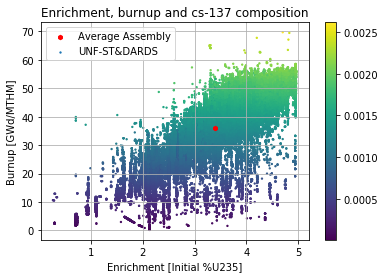

In [110]:
plt.scatter([3.39204], [36.16938], label='Average Assembly', color='red', marker='h', s = 20, zorder=1)
plt.scatter(er, bu, c=cs, marker='.', zorder=-1, label='UNF-ST&DARDS', s=7)
plt.grid()
plt.xlabel('Enrichment [Initial %U235]')
plt.legend()
plt.ylabel('Burnup [GWd/MTHM]')
plt.title('Enrichment, burnup and cs-137 composition')
plt.colorbar()
plt.show()
plt.close()

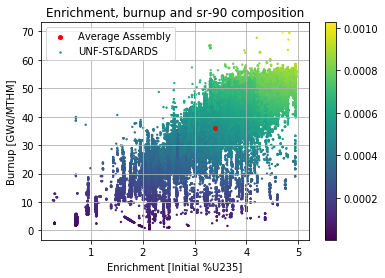

In [111]:
plt.scatter([3.39204], [36.16938], label='Average Assembly', color='red', marker='h', s = 20, zorder=1)
plt.scatter(er, bu, c=sr, marker='.', zorder=-1, label='UNF-ST&DARDS', s=7)
plt.grid()
plt.xlabel('Enrichment [Initial %U235]')
plt.legend()
plt.ylabel('Burnup [GWd/MTHM]')
plt.title('Enrichment, burnup and sr-90 composition')
plt.colorbar()
plt.show()
plt.close()

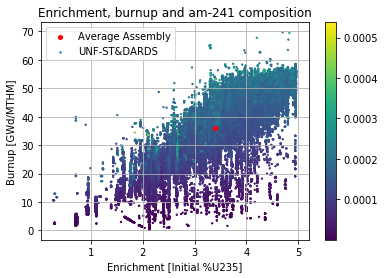

In [112]:
plt.scatter([3.39204], [36.16938], label='Average Assembly', color='red', marker='h', s = 20, zorder=1)
plt.scatter(er, bu, c=am, marker='.', zorder=-1, label='UNF-ST&DARDS', s=7)
plt.grid()
plt.xlabel('Enrichment [Initial %U235]')
plt.legend()
plt.ylabel('Burnup [GWd/MTHM]')
plt.title('Enrichment, burnup and am-241 composition')
plt.colorbar()
plt.show()
plt.close()

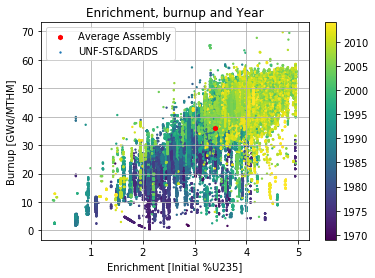

In [ ]:
plt.scatter([3.39204], [36.16938], label='Average Assembly', color='red', marker='h', s = 20, zorder=1)
plt.scatter(er, bu, c=date, marker='.', zorder=-1, label='UNF-ST&DARDS', s=7)
plt.grid()
plt.xlabel('Enrichment [Initial %U235]')
plt.legend()
plt.ylabel('Burnup [GWd/MTHM]')
plt.title('Enrichment, burnup and Year')
plt.colorbar()
plt.show()
plt.close()

In [ ]:
plt.scatter([3.39204], [36.16938], label='Average Assembly', color='red', marker='h', s = 20, zorder=1)
plt.scatter(er, bu, c=pu, marker='.', zorder=-1, label='UNF-ST&DARDS', s=7)
plt.grid()
plt.xlabel('Enrichment [Initial %U235]')
plt.legend()
plt.ylabel('Burnup [GWd/MTHM]')
plt.title('Enrichment, burnup and pu-241 composition')
plt.colorbar()
plt.show()
plt.close()

In [ ]:
plt.scatter([3.39204], [36.16938], label='Average Assembly', color='red', marker='h', s = 20, zorder=1)
plt.scatter(er, bu, c=cm, marker='.', zorder=-1, label='UNF-ST&DARDS', s=7)
plt.grid()
plt.xlabel('Enrichment [Initial %U235]')
plt.legend()
plt.ylabel('Burnup [GWd/MTHM]')
plt.title('Enrichment, burnup and cm-244 composition')
plt.colorbar()
plt.show()
plt.close()